<cell_type>markdown</cell_type># 04 - Phenotype Associations Analysis

## AF Phenotype Discovery from ILR Data

### Objective

Comprehensive analysis of AF phenotype associations with:

**Baseline Characteristics:**
- Demographics & Anthropometrics (age, sex, BMI, BSA, waist circumference, body fat)
- AF History (type, mEHRA symptom score, prior ablation/cardioversion)
- Comorbidities (HTN, DM, HF, stroke/TIA, vascular disease, COPD, OSA)
- Risk Scores (CHA₂DS₂-VASc)
- Medications (beta-blockers, anticoagulation, antiarrhythmics, etc.)
- Laboratory Values (lipids, renal function, glucose, hs-CRP, NT-proBNP, TnT)
- Lifestyle (smoking, alcohol, exercise)

**Imaging & Function:**
- Echocardiography: LV function, LA size/strain, RV function, diastolic function
- BSA-indexed values: LVEDV/BSA, LVESV/BSA, LA area/BSA, SV index, Cardiac Index
- VO₂peak-indexed values (per Letnes et al. 2023): LVEDV/VO₂peak, LA area/VO₂peak
- Cardiopulmonary exercise test (CPET): VO₂peak, HR max, RER, workload, HR recovery

**Trial & Exercise:**
- NEXAF trial arm distribution
- Exercise time changes

**Clinical Outcomes:**
- Hospitalization rates
- Quality of Life (AFEQT, SF-12, EQ-VAS) trajectory
- Post-intervention procedures
- Medication changes (baseline → post)

**Statistical Methods:**
- Kruskal-Wallis H-test for continuous variables
- Chi-square test for categorical variables
- All tables include sample size (N) and p-values

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from src.preprocessing import AFDataLoader

# Display settings
pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 120
%matplotlib inline

# Phenotype colors (enough for up to 6 clusters)
PHENOTYPE_COLORS = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#a65628']

def generate_phenotype_names(features_df, n_phenotypes):
    """Generate descriptive phenotype names based on clustering characteristics."""
    names = {}
    for p in range(n_phenotypes):
        subset = features_df[features_df['phenotype'] == p]
        burden = subset['af_burden_percent'].mean()
        n_eps = subset['n_episodes'].mean()
        duration = subset['mean_episode_duration'].mean()
        names[p] = f'P{p}: {burden:.1f}% burden - {n_eps:.0f} episodes - {duration:.0f} min'
    return names

def get_phenotype_display_cols(n_phenotypes):
    """Generate display column list based on number of phenotypes."""
    return ['Variable', 'Overall'] + [f'P{p}' for p in range(n_phenotypes)] + ['p-value']

def calculate_bsa(height_cm, weight_kg):
    """Calculate Body Surface Area using Dubois formula.
    
    BSA (m²) = 0.007184 × height^0.725 × weight^0.425
    """
    return 0.007184 * (height_cm ** 0.725) * (weight_kg ** 0.425)

def format_pvalue(p):
    """Format p-value for display."""
    if pd.isna(p):
        return 'N/A'
    elif p < 0.001:
        return '<0.001'
    else:
        return f'{p:.3f}'

def create_analysis_table(df, variables_dict, phenotype_col='phenotype', n_phenotypes=4):
    """Create a standardized analysis table with statistics and p-values.
    
    Args:
        df: DataFrame with data
        variables_dict: Dict mapping column names to display labels
        phenotype_col: Name of phenotype column
        n_phenotypes: Number of phenotypes
    
    Returns:
        DataFrame with formatted results
    """
    table_data = []
    
    for col, label in variables_dict.items():
        if col not in df.columns:
            continue
        
        # Determine if continuous or categorical based on dtype and unique values
        dtype = df[col].dtype
        n_unique = df[col].nunique()
        
        # String/object columns are always categorical
        # Numeric columns with <= 5 unique values are treated as categorical
        is_categorical = (dtype == 'object' or dtype.name == 'category' or 
                          (n_unique <= 5 and dtype in ['int64', 'int32', 'float64', 'float32']))
        
        row = {'Variable': label}
        vals = df[col].dropna()
        row['N'] = len(vals)
        
        if not is_categorical:
            # Continuous variable
            try:
                row['Overall'] = f"{vals.mean():.1f} ({vals.std():.1f})" if len(vals) > 0 else 'N/A'
                
                groups = []
                for p in range(n_phenotypes):
                    pvals = df[df[phenotype_col] == p][col].dropna()
                    row[f'P{p}'] = f"{pvals.mean():.1f} ({pvals.std():.1f})" if len(pvals) > 0 else 'N/A'
                    groups.append(pvals)
                
                groups = [g for g in groups if len(g) >= 3]
                if len(groups) > 1:
                    h_stat, p_val = stats.kruskal(*groups)
                    row['p-value'] = p_val
                else:
                    row['p-value'] = np.nan
            except (TypeError, ValueError):
                # If mean/std fails, treat as categorical
                is_categorical = True
        
        if is_categorical:
            # Categorical variable - check if binary (0/1) or multi-category
            unique_vals = vals.unique()
            is_binary = set(unique_vals).issubset({0, 1, 0.0, 1.0})
            
            if is_binary:
                # Binary variable - show % positive
                pct_pos = 100 * (vals == 1).sum() / len(vals) if len(vals) > 0 else 0
                row['Overall'] = f"{pct_pos:.1f}%"
                
                for p in range(n_phenotypes):
                    pvals = df[df[phenotype_col] == p][col].dropna()
                    if len(pvals) > 0:
                        pct = 100 * (pvals == 1).sum() / len(pvals)
                        row[f'P{p}'] = f"{pct:.1f}%"
                    else:
                        row[f'P{p}'] = 'N/A'
            else:
                # Multi-category - show most common value or distribution
                most_common = vals.mode().iloc[0] if len(vals) > 0 else 'N/A'
                row['Overall'] = f"Mode: {most_common}"
                
                for p in range(n_phenotypes):
                    pvals = df[df[phenotype_col] == p][col].dropna()
                    if len(pvals) > 0:
                        mode_val = pvals.mode().iloc[0] if len(pvals.mode()) > 0 else 'N/A'
                        row[f'P{p}'] = f"{mode_val}"
                    else:
                        row[f'P{p}'] = 'N/A'
            
            # Chi-square test for categorical
            try:
                contingency = pd.crosstab(df[phenotype_col], df[col])
                if contingency.shape[1] > 1:
                    chi2, p_val, dof, expected = stats.chi2_contingency(contingency)
                    row['p-value'] = p_val
                else:
                    row['p-value'] = np.nan
            except:
                row['p-value'] = np.nan
        
        table_data.append(row)
    
    return pd.DataFrame(table_data)

---
## 1.5 Curated Clustering Features Reference

The phenotype clustering uses **14 curated features** selected from ~110 candidate features 
(see `02_feature_engineering.ipynb` for the full selection process).

These features were chosen based on:
- **Clinical interpretability**: Directly meaningful to clinicians
- **Discriminative power**: Ability to separate phenotypes (RF importance + ANOVA F-score)
- **Non-redundancy**: Avoiding highly correlated features (r > 0.8)

In [2]:
# Curated features for phenotype clustering with descriptions
CURATED_FEATURES = {
    # BURDEN - Primary AF outcome measures
    'total_af_hours': 'Total hours in AF over follow-up period',
    'af_burden_percent': 'Percentage of time in AF (burden / total time)',
    
    # EPISODE COUNT & PATTERN - Episode characteristics
    'n_episodes': 'Total number of AF episodes',
    'mean_episode_duration': 'Average episode duration (minutes)',
    'max_episode_duration': 'Longest episode duration (minutes)',
    'cv_episode_duration': 'Coefficient of variation of episode duration (variability)',
    'burstiness_index': 'Temporal clustering of episodes (-1=periodic, 0=random, 1=bursty)',
    
    # TEMPORAL PATTERN - When AF occurs
    'pct_daytime_episodes': 'Percentage of episodes starting during daytime (6am-10pm)',
    'hourly_entropy': 'Spread of episodes across hours (higher=more evenly distributed)',
    
    # HEART RATE / RATE CONTROL - Ventricular response
    'mean_ventricular_rate': 'Average heart rate during AF episodes (bpm)',
    'pct_rapid_af': 'Percentage of episodes with rapid ventricular response (>110 bpm)',
    'pct_controlled_af': 'Percentage of episodes with controlled rate (60-110 bpm)',
    
    # TRAJECTORY / PROGRESSION - How AF evolves over time
    'trajectory_slope': 'Rate of AF burden accumulation over time (minutes/day)',
    'longest_plateau_episodes': 'Longest period with minimal AF activity (stability indicator)',
}

# Feature category mapping
FEATURE_CATEGORIES = {
    'total_af_hours': 'Burden',
    'af_burden_percent': 'Burden',
    'n_episodes': 'Episode',
    'mean_episode_duration': 'Episode',
    'max_episode_duration': 'Episode',
    'cv_episode_duration': 'Episode',
    'burstiness_index': 'Episode',
    'pct_daytime_episodes': 'Temporal',
    'hourly_entropy': 'Temporal',
    'mean_ventricular_rate': 'Rate Control',
    'pct_rapid_af': 'Rate Control',
    'pct_controlled_af': 'Rate Control',
    'trajectory_slope': 'Trajectory',
    'longest_plateau_episodes': 'Trajectory',
}

# Category colors for visualization
CATEGORY_COLORS = {
    'Burden': '#e41a1c',
    'Episode': '#377eb8',
    'Temporal': '#4daf4a',
    'Rate Control': '#984ea3',
    'Trajectory': '#ff7f00',
}

print(f"Defined {len(CURATED_FEATURES)} curated features for phenotype clustering")

Defined 14 curated features for phenotype clustering


In [3]:
# Load features and display curated feature summary by phenotype with p-values and importance
_features_df = pd.read_csv('../output/features_with_phenotypes_4k.csv')
_n_phenotypes = _features_df['phenotype'].nunique()

# Calculate feature importance using ANOVA F-scores
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler

# Prepare data for importance calculation
curated_cols = [f for f in CURATED_FEATURES.keys() if f in _features_df.columns]
X_curated = _features_df[curated_cols].fillna(_features_df[curated_cols].median())
X_scaled = StandardScaler().fit_transform(X_curated)
y = _features_df['phenotype'].values

f_scores, f_pvals = f_classif(X_scaled, y)
importance_dict = dict(zip(curated_cols, f_scores))
importance_max = max(f_scores) if max(f_scores) > 0 else 1

# Build feature summary table with p-values and importance
feature_rows = []
for feat, desc in CURATED_FEATURES.items():
    if feat in _features_df.columns:
        row = {
            'Feature': feat,
            'Description': desc,
            'Category': FEATURE_CATEGORIES.get(feat, 'Other'),
        }
        # Add mean per phenotype
        groups = []
        for p in range(_n_phenotypes):
            subset = _features_df[_features_df['phenotype'] == p][feat].dropna()
            row[f'P{p}'] = f"{subset.mean():.1f}"
            groups.append(subset.values)
        
        # Kruskal-Wallis p-value
        try:
            stat, pval = stats.kruskal(*groups)
            row['p-value'] = pval
        except:
            row['p-value'] = np.nan
        
        # Feature importance (normalized F-score)
        row['Importance'] = importance_dict.get(feat, 0) / importance_max
        
        feature_rows.append(row)

ilr_features_df = pd.DataFrame(feature_rows)

# Sort by importance
ilr_features_df = ilr_features_df.sort_values('Importance', ascending=False)

# Format for display
print("=" * 100)
print("ILR MONITORING FEATURES - Mean Values by Phenotype with Statistical Tests")
print("=" * 100)
print()

# Display with category grouping
for category in ['Burden', 'Episode', 'Temporal', 'Rate Control', 'Trajectory']:
    cat_df = ilr_features_df[ilr_features_df['Category'] == category].copy()
    if len(cat_df) > 0:
        print(f"\n{category.upper()}")
        print("-" * 80)
        for _, row in cat_df.iterrows():
            feat_name = row['Feature']
            desc = row['Description']
            means = ' | '.join([f"P{p}: {row[f'P{p}']}" for p in range(_n_phenotypes)])
            pval_str = f"p={row['p-value']:.4f}" if pd.notna(row['p-value']) else "p=N/A"
            imp_str = f"Imp={row['Importance']:.2f}"
            print(f"  {feat_name} ({pval_str}, {imp_str})")
            print(f"    {desc}")
            print(f"    {means}")

# Display as formatted table
print("\n")
display_cols = ['Feature', 'Category'] + [f'P{p}' for p in range(_n_phenotypes)] + ['p-value', 'Importance']
display_df = ilr_features_df[display_cols].copy()
display_df['p-value'] = display_df['p-value'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
display_df['Importance'] = display_df['Importance'].apply(lambda x: f"{x:.2f}")
display(display_df)

ILR MONITORING FEATURES - Mean Values by Phenotype with Statistical Tests


BURDEN
--------------------------------------------------------------------------------
  af_burden_percent (p=0.0000, Imp=1.00)
    Percentage of time in AF (burden / total time)
    P0: 47.4 | P1: 2.2 | P2: 6.7 | P3: 0.8
  total_af_hours (p=0.0000, Imp=0.81)
    Total hours in AF over follow-up period
    P0: 3684.6 | P1: 149.9 | P2: 530.6 | P3: 35.5

EPISODE
--------------------------------------------------------------------------------
  max_episode_duration (p=0.0000, Imp=0.30)
    Longest episode duration (minutes)
    P0: 47914.3 | P1: 1199.7 | P2: 2817.3 | P3: 1430.2
  burstiness_index (p=0.0000, Imp=0.20)
    Temporal clustering of episodes (-1=periodic, 0=random, 1=bursty)
    P0: 0.4 | P1: 0.2 | P2: 0.4 | P3: -0.2
  cv_episode_duration (p=0.0000, Imp=0.09)
    Coefficient of variation of episode duration (variability)
    P0: 4.4 | P1: 1.3 | P2: 2.2 | P3: 0.5
  n_episodes (p=0.0000, Imp=0.07)
    To

,Feature,Category,P0,P1,P2,P3,p-value,Importance
1,af_burden_percent,Burden,47.4,2.2,6.7,0.8,0.0000,1.00
10,pct_rapid_af,Rate Control,15.9,83.2,17.6,11.1,0.0000,0.99
11,pct_controlled_af,Rate Control,72.7,16.7,75.9,87.3,0.0000,0.89
0,total_af_hours,Burden,3684.6,149.9,530.6,35.5,0.0000,0.81
9,mean_ventricular_rate,Rate Control,85.2,128.6,86.9,88.2,0.0000,0.57
8,hourly_entropy,Temporal,3.8,2.8,4.1,1.6,0.0000,0.32
4,max_episode_duration,Episode,47914.3,1199.7,2817.3,1430.2,0.0000,0.30
13,longest_plateau_episodes,Trajectory,3.6,2.0,4.5,0.6,0.0000,0.22
6,burstiness_index,Episode,0.4,0.2,0.4,-0.2,0.0000,0.20
12,trajectory_slope,Trajectory,798.2,62.5,120.9,75.7,0.0000,0.17


---
## 1. Load Data

In [4]:
# Load phenotype assignments
features_df = pd.read_csv('../output/features_with_phenotypes_4k.csv')

# Detect number of phenotypes dynamically
N_PHENOTYPES = features_df['phenotype'].nunique()
PHENOTYPE_NAMES = generate_phenotype_names(features_df, N_PHENOTYPES)

print(f"Phenotype data: {features_df.shape}")
print(f"  Patients: {len(features_df)}")
print(f"  Phenotypes detected: {N_PHENOTYPES}")
print(f"\nPhenotype names:")
for p, name in PHENOTYPE_NAMES.items():
    print(f"  {name}")

Phenotype data: (246, 16)
  Patients: 246
  Phenotypes detected: 4

Phenotype names:
  P0: 47.4% burden - 1140 episodes - 6573 min
  P1: 2.2% burden - 133 episodes - 175 min
  P2: 6.7% burden - 458 episodes - 230 min
  P3: 0.8% burden - 6 episodes - 706 min


In [5]:
# Load baseline and burden data
loader = AFDataLoader()
df_baseline = loader.load_baseline()
df_burden = loader.load_burden()

# Fix ID types for merging
features_df['ID'] = features_df['ID'].astype(int).astype(str)
df_baseline['ID'] = df_baseline['ID'].astype(str)
df_burden['ID'] = df_burden['ID'].astype(int).astype(str)

print(f"Baseline data: {df_baseline.shape}")
print(f"Burden/outcome data: {df_burden.shape}")

Baseline data: (295, 714)
Burden/outcome data: (294, 1155)


<cell_type>markdown</cell_type>---
## 2. Baseline Characteristics

Comprehensive analysis of demographics, anthropometrics, AF history, comorbidities, medications, laboratory values, lifestyle, and risk scores.

In [6]:
# Comprehensive baseline variables organized by domain
baseline_vars = {
    # Demographics
    'Alder': 'Age (years)',
    'Kjønn': 'Male Sex',
    
    # Anthropometrics
    'BL_høyde': 'Height (cm)',
    'BL_vekt': 'Weight (kg)',
    'BL_BMI': 'BMI (kg/m²)',
    'BL_midjemål': 'Waist Circumference (cm)',
    'BL_fettprosent': 'Body Fat (%)',
    
    # AF History
    'BL_AF_type': 'Paroxysmal AF',
    'BL_mEHRA': 'mEHRA Score',
    'BL_ablasjon_nei_ja': 'Prior Ablation',
    'BL_ablasjon_antall': 'Number of Prior Ablations',
    'BL_konvertering_nei_ja': 'Prior Cardioversion',
    'BL_konvertering_antall': 'Number of Prior Cardioversions',
    
    # Comorbidities
    'BL_HTN': 'Hypertension',
    'BL_DM2': 'Diabetes Type 2',
    'BL_DM1': 'Diabetes Type 1',
    'BL_komb.DM': 'Diabetes (any)',
    'BL_NSTEMI': 'Prior NSTEMI',
    'BL_STEMI': 'Prior STEMI',
    'BL_angina': 'Angina Pectoris',
    'BL_CABG': 'Prior CABG',
    'BL_HFrEF': 'HFrEF',
    'BL_HFpEF': 'HFpEF',
    'BL_komb.HF': 'Heart Failure (any)',
    'BL_hjerneinfarkt': 'Prior Stroke',
    'BL_TIA': 'Prior TIA',
    'BL_komb.TIAinfarkt': 'Cerebrovascular Event (any)',
    'BL_karsykdom': 'Vascular Disease',
    'BL_komb.karsykdom': 'Vascular Disease (combined)',
    'BL_COPD': 'COPD',
    'BL_OSA': 'Sleep Apnea (OSA)',
    
    # Risk Scores
    'CHA2DS2VA': 'CHA₂DS₂-VASc Score',
    
    # Medications
    'BL_betabl': 'Beta-blocker (baseline)',
    'BL_betablokker_idag': 'Beta-blocker (day of test)',
    'BL_antikoag': 'Anticoagulation',
    'BL_antiarrytm': 'Antiarrhythmic',
    'BL_platehemmende': 'Antiplatelet',
    'BL_blodtrykkssenkende': 'Antihypertensive',
    'BL_kolesterolsenkende': 'Lipid-lowering',
    'BL_kalsiumantagonist': 'Calcium Channel Blocker',
    
    # Laboratory Values
    'BL_kolesterol_total': 'Total Cholesterol (mmol/L)',
    'BL_HDL': 'HDL Cholesterol (mmol/L)',
    'BL_LDL': 'LDL Cholesterol (mmol/L)',
    'BL_triglyserider': 'Triglycerides (mmol/L)',
    'BL_kreatinin': 'Creatinine (μmol/L)',
    'BL_eGFR': 'eGFR (mL/min/1.73m²)',
    'BL_glukose': 'Fasting Glucose (mmol/L)',
    'BL_hsCRP_pre': 'hs-CRP (mg/L)',
    'BL_NTproBNP_pre': 'NT-proBNP (pg/mL)',
    'BL_TnT_pre': 'Troponin T (ng/L)',
    
    # Lifestyle
    'BL_Smoking_status': 'Current Smoker',
    'BL_AlcFLY': 'Alcohol Frequency',
    'BL_ExeMin': 'Exercise (min/week)',
}

# Merge phenotypes with baseline
available_vars = {k: v for k, v in baseline_vars.items() if k in df_baseline.columns}
baseline_cols = ['ID'] + list(available_vars.keys())
df = features_df[['ID', 'phenotype']].merge(
    df_baseline[baseline_cols], on='ID', how='left'
)

# Calculate BSA for later indexed calculations
if 'BL_høyde' in df.columns and 'BL_vekt' in df.columns:
    df['BSA'] = calculate_bsa(df['BL_høyde'], df['BL_vekt'])
    available_vars['BSA'] = 'BSA (m²)'

print(f"Merged dataset: {df.shape}")
print(f"Available baseline variables: {len(available_vars)}")

Merged dataset: (246, 55)
Available baseline variables: 53


In [7]:
# Create comprehensive baseline characteristics tables by domain

# --- Demographics & Anthropometrics ---
demo_vars = {k: v for k, v in available_vars.items() if k in [
    'Alder', 'Kjønn', 'BL_høyde', 'BL_vekt', 'BL_BMI', 'BL_midjemål', 'BL_fettprosent', 'BSA'
]}
demo_table = create_analysis_table(df, demo_vars, n_phenotypes=N_PHENOTYPES)
demo_display = ['Variable', 'N', 'Overall'] + [f'P{p}' for p in range(N_PHENOTYPES)] + ['p-value']

print("DEMOGRAPHICS & ANTHROPOMETRICS")
print("=" * 100)
display(demo_table.sort_values('p-value')[demo_display])

# --- AF History ---
af_vars = {k: v for k, v in available_vars.items() if k in [
    'BL_AF_type', 'BL_mEHRA', 'BL_ablasjon_nei_ja', 'BL_ablasjon_antall',
    'BL_konvertering_nei_ja', 'BL_konvertering_antall'
]}
af_table = create_analysis_table(df, af_vars, n_phenotypes=N_PHENOTYPES)

print("\nAF HISTORY")
print("=" * 100)
display(af_table.sort_values('p-value')[demo_display])

# --- Comorbidities ---
comorb_vars = {k: v for k, v in available_vars.items() if k in [
    'BL_HTN', 'BL_DM2', 'BL_DM1', 'BL_komb.DM', 'BL_NSTEMI', 'BL_STEMI', 
    'BL_angina', 'BL_CABG', 'BL_HFrEF', 'BL_HFpEF', 'BL_komb.HF',
    'BL_hjerneinfarkt', 'BL_TIA', 'BL_komb.TIAinfarkt', 'BL_karsykdom',
    'BL_komb.karsykdom', 'BL_COPD', 'BL_OSA', 'CHA2DS2VA'
]}
comorb_table = create_analysis_table(df, comorb_vars, n_phenotypes=N_PHENOTYPES)

print("\nCOMORBIDITIES & RISK SCORES")
print("=" * 100)
display(comorb_table.sort_values('p-value')[demo_display])

# --- Medications ---
med_vars = {k: v for k, v in available_vars.items() if k in [
    'BL_betabl', 'BL_betablokker_idag', 'BL_antikoag', 'BL_antiarrytm',
    'BL_platehemmende', 'BL_blodtrykkssenkende', 'BL_kolesterolsenkende', 'BL_kalsiumantagonist'
]}
med_table = create_analysis_table(df, med_vars, n_phenotypes=N_PHENOTYPES)

print("\nMEDICATIONS")
print("=" * 100)
display(med_table.sort_values('p-value')[demo_display])

# --- Laboratory Values ---
lab_vars = {k: v for k, v in available_vars.items() if k in [
    'BL_kolesterol_total', 'BL_HDL', 'BL_LDL', 'BL_triglyserider',
    'BL_kreatinin', 'BL_eGFR', 'BL_glukose', 'BL_hsCRP_pre', 'BL_NTproBNP_pre', 'BL_TnT_pre'
]}
lab_table = create_analysis_table(df, lab_vars, n_phenotypes=N_PHENOTYPES)

print("\nLABORATORY VALUES")
print("=" * 100)
display(lab_table.sort_values('p-value')[demo_display])

# --- Lifestyle ---
life_vars = {k: v for k, v in available_vars.items() if k in [
    'BL_Smoking_status', 'BL_AlcFLY', 'BL_ExeMin'
]}
life_table = create_analysis_table(df, life_vars, n_phenotypes=N_PHENOTYPES)

print("\nLIFESTYLE")
print("=" * 100)
display(life_table.sort_values('p-value')[demo_display])

# Combine all tables for export
all_baseline = pd.concat([
    demo_table.assign(Category='Demographics'),
    af_table.assign(Category='AF History'),
    comorb_table.assign(Category='Comorbidities'),
    med_table.assign(Category='Medications'),
    lab_table.assign(Category='Laboratory'),
    life_table.assign(Category='Lifestyle')
], ignore_index=True)

print(f"\n\nTotal baseline variables analyzed: {len(all_baseline)}")
print(f"Significant associations (p<0.05): {(all_baseline['p-value'] < 0.05).sum()}")

DEMOGRAPHICS & ANTHROPOMETRICS


,Variable,N,Overall,P0,P1,P2,P3,p-value
0,Age (years),246,64.3 (10.4),67.8 (9.1),61.2 (10.3),65.6 (9.7),64.8 (11.3),0.005442
2,Height (cm),246,177.2 (9.4),174.6 (7.8),178.2 (9.6),177.2 (8.8),176.7 (10.5),0.359202
6,Body Fat (%),159,30.6 (8.8),33.5 (7.5),30.1 (8.0),30.3 (9.1),30.5 (9.8),0.457859
4,BMI (kg/m²),246,27.6 (4.8),28.5 (4.9),27.6 (5.1),27.7 (4.6),27.2 (4.9),0.619686
5,Waist Circumference (cm),241,99.5 (13.5),102.6 (15.1),98.6 (14.7),100.0 (12.4),98.9 (12.9),0.642987
1,Male Sex,245,Mode: 1.0,1.0,1.0,1.0,1.0,0.844028
3,Weight (kg),246,86.8 (17.0),87.0 (17.2),87.9 (18.8),87.1 (16.3),84.8 (15.8),0.883738
7,BSA (m²),246,2.0 (0.2),2.0 (0.2),2.1 (0.2),2.0 (0.2),2.0 (0.2),0.914040



AF HISTORY


,Variable,N,Overall,P0,P1,P2,P3,p-value
0,Paroxysmal AF,246,Mode: 1.0,2.0,1.0,1.0,1.0,0.002305
1,mEHRA Score,246,Mode: 3,2b,2b,3,3,0.134497
3,Number of Prior Ablations,47,Mode: 1.0,1.0,1.0,1.0,1.0,0.174308
4,Prior Cardioversion,246,41.5%,59.1%,36.8%,42.0%,40.0%,0.314276
2,Prior Ablation,246,19.5%,18.2%,15.8%,23.9%,18.3%,0.612862
5,Number of Prior Cardioversions,101,3.1 (3.7),3.3 (4.0),3.6 (4.5),3.2 (3.7),2.2 (2.1),0.703580



COMORBIDITIES & RISK SCORES


,Variable,N,Overall,P0,P1,P2,P3,p-value
18,CHA₂DS₂-VASc Score,246,1.5 (1.4),2.0 (1.4),1.2 (1.2),1.6 (1.4),1.7 (1.5),0.025452
1,Diabetes Type 2,246,5.3%,0.0%,7.9%,1.1%,10.0%,0.046999
3,Diabetes (any),246,6.1%,4.5%,9.2%,1.1%,10.0%,0.080040
2,Diabetes Type 1,244,0.8%,4.5%,1.3%,0.0%,0.0%,0.158179
4,Prior NSTEMI,245,1.2%,4.5%,0.0%,2.3%,0.0%,0.214163
5,Prior STEMI,246,2.4%,4.5%,1.3%,4.5%,0.0%,0.266464
15,Vascular Disease (combined),246,14.2%,9.1%,9.2%,15.9%,20.0%,0.274105
13,Cerebrovascular Event (any),246,Mode: 0.0,0.0,0.0,0.0,0.0,0.305390
12,Prior TIA,245,3.3%,4.5%,1.3%,2.3%,6.8%,0.306771
0,Hypertension,246,42.3%,54.5%,36.8%,46.6%,38.3%,0.343450



MEDICATIONS


,Variable,N,Overall,P0,P1,P2,P3,p-value
2,Anticoagulation,246,67.1%,86.4%,52.6%,70.5%,73.3%,0.006119
7,Calcium Channel Blocker,246,17.1%,22.7%,10.5%,26.1%,10.0%,0.018370
6,Lipid-lowering,244,34.8%,36.4%,22.4%,46.0%,33.9%,0.018511
5,Antihypertensive,245,43.7%,68.2%,34.2%,48.9%,39.0%,0.021992
1,Beta-blocker (day of test),241,27.8%,38.1%,18.7%,29.1%,33.9%,0.145486
0,Beta-blocker (baseline),244,36.1%,45.5%,28.9%,36.4%,41.4%,0.358257
3,Antiarrhythmic,245,13.9%,13.6%,9.2%,15.9%,16.9%,0.540717
4,Antiplatelet,238,2.9%,0.0%,3.9%,2.4%,3.6%,0.780249



LABORATORY VALUES


,Variable,N,Overall,P0,P1,P2,P3,p-value
2,LDL Cholesterol (mmol/L),243,3.1 (1.0),2.7 (0.9),3.4 (1.0),3.0 (1.0),2.9 (1.0),0.001737
9,Troponin T (ng/L),155,9.3 (4.6),11.1 (5.0),7.7 (3.7),9.9 (4.3),10.0 (5.4),0.011067
8,NT-proBNP (pg/mL),152,160.5 (182.8),223.9 (195.3),109.9 (119.9),191.3 (236.3),157.7 (131.7),0.023548
0,Total Cholesterol (mmol/L),242,4.8 (1.0),4.5 (0.9),5.1 (1.1),4.7 (1.0),4.6 (1.0),0.025465
5,eGFR (mL/min/1.73m²),243,82.5 (12.3),75.1 (16.8),84.4 (11.1),81.1 (11.9),84.7 (11.7),0.047165
7,hs-CRP (mg/L),235,2.5 (3.6),2.4 (1.6),2.8 (2.6),2.3 (4.9),2.6 (2.6),0.068403
1,HDL Cholesterol (mmol/L),243,1.4 (0.5),1.6 (0.5),1.4 (0.4),1.5 (0.6),1.4 (0.4),0.258313
3,Triglycerides (mmol/L),242,1.2 (0.6),1.0 (0.3),1.3 (0.6),1.2 (0.6),1.2 (0.8),0.313410
4,Creatinine (μmol/L),244,76.5 (14.5),81.2 (20.8),75.0 (12.5),78.0 (15.2),74.7 (13.2),0.515544
6,Fasting Glucose (mmol/L),243,5.9 (4.1),5.6 (0.5),6.4 (7.2),5.6 (0.7),5.6 (1.0),0.733337



LIFESTYLE


,Variable,N,Overall,P0,P1,P2,P3,p-value
1,Alcohol Frequency,246,Mode: 3,3,3,4,3,0.480765
0,Current Smoker,240,Mode: 2.0,2.0,2.0,2.0,2.0,0.937461




Total baseline variables analyzed: 53
Significant associations (p<0.05): 13


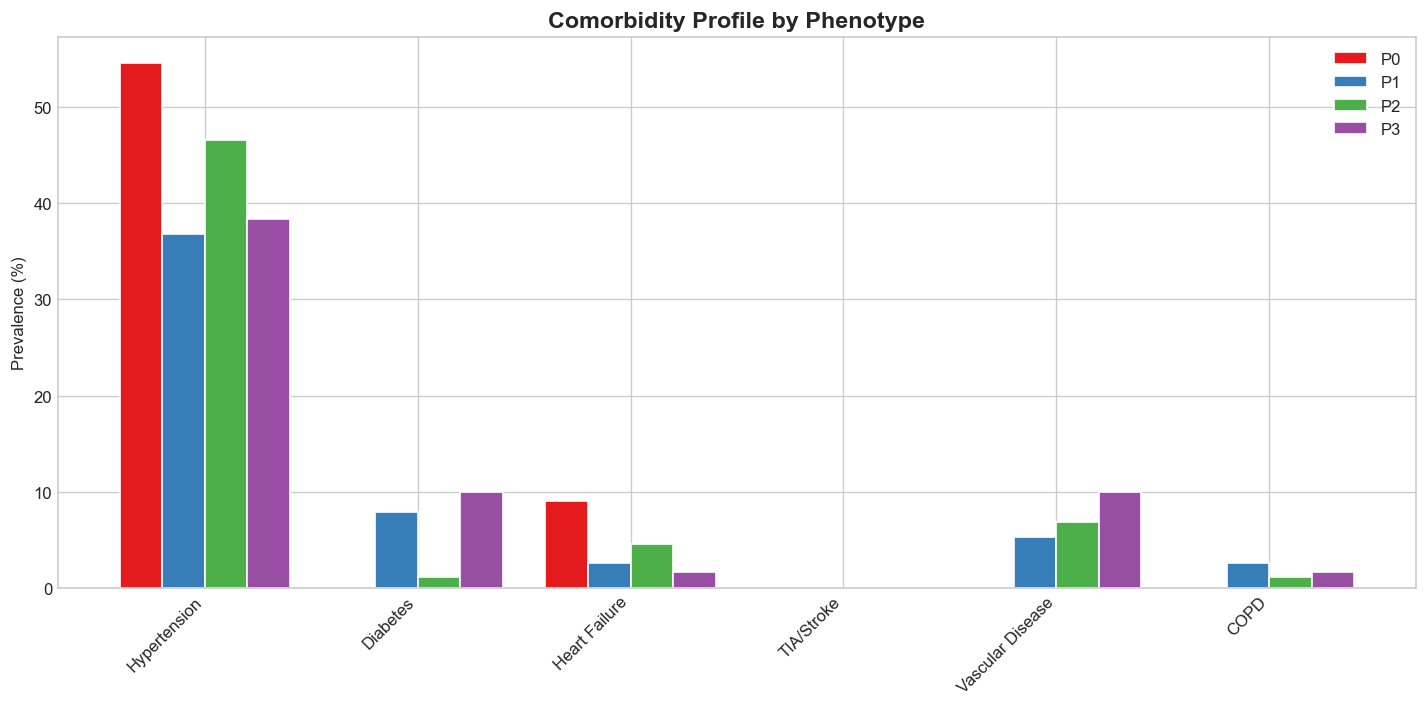

In [8]:
# Visualize comorbidities
comorbidity_vars = ['BL_HTN', 'BL_DM2', 'BL_komb.HF', 'BL_komb.TIAinfarkt', 'BL_karsykdom', 'BL_COPD']
comorbidity_labels = ['Hypertension', 'Diabetes', 'Heart Failure', 'TIA/Stroke', 'Vascular Disease', 'COPD']
available_comorb = [(v, l) for v, l in zip(comorbidity_vars, comorbidity_labels) if v in df.columns]

if len(available_comorb) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(available_comorb))
    width = 0.8 / N_PHENOTYPES
    
    for p in range(N_PHENOTYPES):
        rates = []
        for col, label in available_comorb:
            vals = df[df['phenotype'] == p][col].dropna()
            rate = 100 * (vals == 1).sum() / len(vals) if len(vals) > 0 else 0
            rates.append(rate)
        offset = (p - (N_PHENOTYPES - 1) / 2) * width
        ax.bar(x + offset, rates, width, label=f'P{p}', color=PHENOTYPE_COLORS[p])
    
    ax.set_xticks(x)
    ax.set_xticklabels([l for v, l in available_comorb], rotation=45, ha='right')
    ax.set_ylabel('Prevalence (%)')
    ax.set_title('Comorbidity Profile by Phenotype', fontsize=14, fontweight='bold')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('../output/figures/baseline_comorbidities.png', dpi=150, bbox_inches='tight')
    plt.show()

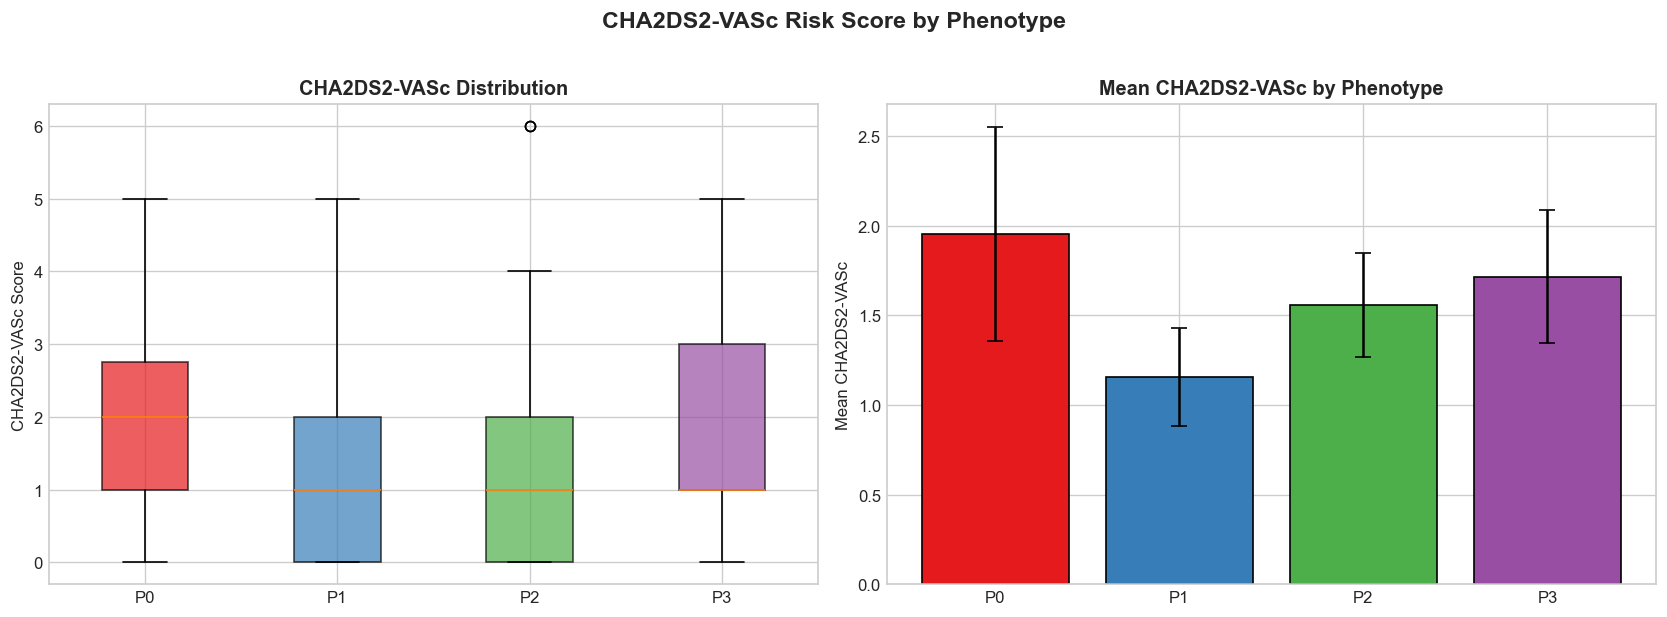

In [9]:
# CHA2DS2-VASc by phenotype
if 'CHA2DS2VA' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    box_data = [df[df['phenotype'] == p]['CHA2DS2VA'].dropna() for p in range(N_PHENOTYPES)]
    bp = axes[0].boxplot(box_data, patch_artist=True, positions=range(N_PHENOTYPES))
    
    for patch, color in zip(bp['boxes'], PHENOTYPE_COLORS[:N_PHENOTYPES]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[0].set_xticks(range(N_PHENOTYPES))
    axes[0].set_xticklabels([f'P{i}' for i in range(N_PHENOTYPES)])
    axes[0].set_ylabel('CHA2DS2-VASc Score')
    axes[0].set_title('CHA2DS2-VASc Distribution', fontweight='bold')
    
    means = [df[df['phenotype'] == p]['CHA2DS2VA'].mean() for p in range(N_PHENOTYPES)]
    cis = [1.96 * df[df['phenotype'] == p]['CHA2DS2VA'].std() / 
           np.sqrt(len(df[df['phenotype'] == p])) for p in range(N_PHENOTYPES)]
    
    axes[1].bar(range(N_PHENOTYPES), means, color=PHENOTYPE_COLORS[:N_PHENOTYPES], edgecolor='black')
    axes[1].errorbar(range(N_PHENOTYPES), means, yerr=cis, fmt='none', color='black', capsize=5)
    axes[1].set_xticks(range(N_PHENOTYPES))
    axes[1].set_xticklabels([f'P{i}' for i in range(N_PHENOTYPES)])
    axes[1].set_ylabel('Mean CHA2DS2-VASc')
    axes[1].set_title('Mean CHA2DS2-VASc by Phenotype', fontweight='bold')
    
    plt.suptitle('CHA2DS2-VASc Risk Score by Phenotype', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('../output/figures/baseline_cha2ds2vasc.png', dpi=150, bbox_inches='tight')
    plt.show()

<cell_type>markdown</cell_type>---
## 3. Echocardiography

Comprehensive echo analysis including:
- **LV function**: EF, volumes, stroke volume, cardiac output
- **LA assessment**: Diameter, area/volume, strain (reservoir, conduit, contractile)
- **RV function**: TAPSE, S' velocity
- **Diastolic function**: E/A ratio, E/e' ratio
- **Indexed values**: Volumes indexed to BSA and VO₂peak (per Letnes et al. 2023, EJCI)

In [10]:
# Comprehensive echo variables
echo_vars = {
    # LV Function
    'BL_lvef_bip_ai': 'LV EF Biplane (%)',
    'BL_ef_biplane_03_percent': 'LV EF Biplane Alt (%)',
    'BL_lvedv_bip_ai': 'LV EDV (ml)',
    'BL_lvesv_bip_ai': 'LV ESV (ml)',
    'BL_lvot_sv_ml': 'Stroke Volume (ml)',
    'BL_lvot_co_l_min': 'Cardiac Output (L/min)',
    
    # LA Assessment
    'BL_la_cm': 'LA Diameter (cm)',
    'BL_la_as_a4c_cm2': 'LA Area 4C (cm²)',
    'BL_auto_laq_gls_r_percent': 'LA Reservoir Strain (%)',
    'BL_auto_laq_gls_cd_percent': 'LA Conduit Strain (%)',
    'BL_auto_laq_gls_ct_percent': 'LA Contractile Strain (%)',
    
    # RV Function
    'BL_mm_tapse_cm': 'TAPSE (cm)',
    'BL_rv_sprime_velocity_m_s': 'RV S\' Velocity (m/s)',
    
    # Diastolic Function
    'BL_mv_e_velocity_m_s': 'Mitral E Velocity (m/s)',
    'BL_mv_a_velocity_m_s': 'Mitral A Velocity (m/s)',
    'BL_mv_e_a_ratio_1': 'E/A Ratio',
    'BL_mv_e_eprime_average_ratio_calc_1': 'E/e\' Average',
}

# Merge echo data with BSA and VO2peak for indexing
echo_cols = ['ID'] + [c for c in echo_vars.keys() if c in df_baseline.columns]
df_echo = features_df[['ID', 'phenotype']].merge(df_baseline[echo_cols], on='ID', how='inner')

# Add BSA from earlier calculation
if 'BL_høyde' in df_baseline.columns and 'BL_vekt' in df_baseline.columns:
    df_echo = df_echo.merge(
        df_baseline[['ID', 'BL_høyde', 'BL_vekt']].assign(
            BSA=lambda x: calculate_bsa(x['BL_høyde'], x['BL_vekt'])
        )[['ID', 'BSA']], 
        on='ID', how='left'
    )

# Add VO2peak for cardiac volume indexing (Letnes et al. 2023 approach)
if 'BL_CPET_max_VO2_lmin' in df_baseline.columns:
    df_echo = df_echo.merge(
        df_baseline[['ID', 'BL_CPET_max_VO2_lmin']].rename(columns={'BL_CPET_max_VO2_lmin': 'VO2peak_Lmin'}),
        on='ID', how='left'
    )

# Calculate indexed values
# Indexed to BSA
if 'BSA' in df_echo.columns:
    if 'BL_lvedv_bip_ai' in df_echo.columns:
        df_echo['LVEDV_BSA'] = df_echo['BL_lvedv_bip_ai'] / df_echo['BSA']
    if 'BL_lvesv_bip_ai' in df_echo.columns:
        df_echo['LVESV_BSA'] = df_echo['BL_lvesv_bip_ai'] / df_echo['BSA']
    if 'BL_la_as_a4c_cm2' in df_echo.columns:
        df_echo['LAarea_BSA'] = df_echo['BL_la_as_a4c_cm2'] / df_echo['BSA']
    if 'BL_lvot_sv_ml' in df_echo.columns:
        df_echo['SV_BSA'] = df_echo['BL_lvot_sv_ml'] / df_echo['BSA']
    if 'BL_lvot_co_l_min' in df_echo.columns:
        df_echo['CI'] = df_echo['BL_lvot_co_l_min'] / df_echo['BSA']  # Cardiac Index

# Indexed to VO2peak (physiological indexing - Letnes et al. 2023)
if 'VO2peak_Lmin' in df_echo.columns:
    if 'BL_lvedv_bip_ai' in df_echo.columns:
        df_echo['LVEDV_VO2'] = df_echo['BL_lvedv_bip_ai'] / df_echo['VO2peak_Lmin']
    if 'BL_lvesv_bip_ai' in df_echo.columns:
        df_echo['LVESV_VO2'] = df_echo['BL_lvesv_bip_ai'] / df_echo['VO2peak_Lmin']
    if 'BL_la_as_a4c_cm2' in df_echo.columns:
        df_echo['LAarea_VO2'] = df_echo['BL_la_as_a4c_cm2'] / df_echo['VO2peak_Lmin']

# Add indexed values to variable dictionary
indexed_vars = {
    'LVEDV_BSA': 'LVEDV/BSA (ml/m²)',
    'LVESV_BSA': 'LVESV/BSA (ml/m²)',
    'LAarea_BSA': 'LA Area/BSA (cm²/m²)',
    'SV_BSA': 'Stroke Volume Index (ml/m²)',
    'CI': 'Cardiac Index (L/min/m²)',
    'LVEDV_VO2': 'LVEDV/VO₂peak (ml/L/min)',
    'LVESV_VO2': 'LVESV/VO₂peak (ml/L/min)',
    'LAarea_VO2': 'LA Area/VO₂peak (cm²/L/min)',
}

print(f"Echo dataset: {df_echo.shape}")
print(f"\nIndexed values calculated:")

Echo dataset: (246, 29)

Indexed values calculated:


In [11]:
# Create comprehensive echo tables

# --- Raw Echo Values ---
raw_echo_table = create_analysis_table(df_echo, echo_vars, n_phenotypes=N_PHENOTYPES)
echo_display = ['Variable', 'N', 'Overall'] + [f'P{p}' for p in range(N_PHENOTYPES)] + ['p-value']

print("RAW ECHOCARDIOGRAPHIC PARAMETERS")
print("=" * 100)
display(raw_echo_table.sort_values('p-value')[echo_display])

# --- BSA-Indexed Values ---
bsa_indexed_vars = {k: v for k, v in indexed_vars.items() if k in df_echo.columns and 'BSA' in k or k == 'CI' or k == 'SV_BSA'}
bsa_indexed_vars = {k: v for k, v in indexed_vars.items() if k in df_echo.columns and ('BSA' in k or k == 'CI')}
bsa_table = create_analysis_table(df_echo, bsa_indexed_vars, n_phenotypes=N_PHENOTYPES)

print("\nBSA-INDEXED VALUES (Traditional Indexing)")
print("=" * 100)
display(bsa_table.sort_values('p-value')[echo_display])

# --- VO2peak-Indexed Values (Letnes et al. 2023) ---
vo2_indexed_vars = {k: v for k, v in indexed_vars.items() if k in df_echo.columns and 'VO2' in k}
vo2_table = create_analysis_table(df_echo, vo2_indexed_vars, n_phenotypes=N_PHENOTYPES)

print("\nVO₂peak-INDEXED VALUES (Physiological Indexing)")
print("Per Letnes et al. 2023 (EJCI): 'Indexing cardiac volumes to VO₂peak helps")
print("differentiate physiological from pathological cardiac remodeling.'")
print("=" * 100)
display(vo2_table.sort_values('p-value')[echo_display])

# Combine all echo tables
all_echo = pd.concat([
    raw_echo_table.assign(Category='Raw'),
    bsa_table.assign(Category='BSA-Indexed'),
    vo2_table.assign(Category='VO2-Indexed')
], ignore_index=True)

print(f"\nTotal echo variables analyzed: {len(all_echo)}")
print(f"Significant associations (p<0.05): {(all_echo['p-value'] < 0.05).sum()}")

RAW ECHOCARDIOGRAPHIC PARAMETERS


,Variable,N,Overall,P0,P1,P2,P3,p-value
7,LA Area 4C (cm²),155,23.9 (4.6),25.3 (3.8),22.7 (4.6),25.0 (3.9),23.2 (5.6),0.014044
6,LA Diameter (cm),154,4.2 (0.6),4.4 (0.6),4.1 (0.6),4.3 (0.5),4.1 (0.6),0.023820
5,Cardiac Output (L/min),147,5.0 (1.2),5.1 (0.8),5.3 (1.3),4.7 (1.1),5.1 (1.1),0.047486
16,E/e' Average,153,7.4 (2.4),8.5 (2.5),6.7 (2.0),7.4 (2.2),7.7 (2.8),0.074012
2,LV EDV (ml),214,118.6 (26.3),121.9 (33.5),116.9 (25.7),123.0 (27.0),112.7 (22.2),0.155611
1,LV EF Biplane Alt (%),23,64.0 (8.3),67.3 (1.1),61.9 (7.1),62.1 (10.0),70.8 (7.5),0.197891
3,LV ESV (ml),210,57.0 (16.1),58.8 (21.3),56.6 (14.3),59.5 (17.6),53.0 (13.1),0.222799
13,Mitral E Velocity (m/s),155,0.6 (0.1),0.6 (0.1),0.5 (0.1),0.6 (0.1),0.6 (0.2),0.275983
14,Mitral A Velocity (m/s),155,0.5 (0.2),0.6 (0.2),0.5 (0.2),0.5 (0.2),0.6 (0.2),0.290180
12,RV S' Velocity (m/s),154,0.1 (0.0),0.1 (0.0),0.1 (0.0),0.1 (0.0),0.1 (0.0),0.443739



BSA-INDEXED VALUES (Traditional Indexing)


,Variable,N,Overall,P0,P1,P2,P3,p-value
2,LA Area/BSA (cm²/m²),155,11.6 (2.2),12.5 (2.0),10.9 (2.0),12.2 (1.9),11.5 (2.9),0.003412
4,Cardiac Index (L/min/m²),147,2.4 (0.5),2.5 (0.4),2.5 (0.5),2.3 (0.5),2.5 (0.5),0.102903
0,LVEDV/BSA (ml/m²),214,58.2 (10.1),59.6 (11.7),57.3 (9.7),60.3 (10.9),55.6 (8.3),0.152630
1,LVESV/BSA (ml/m²),210,27.9 (6.5),28.6 (8.1),27.6 (5.6),29.1 (7.5),26.0 (5.1),0.159858
3,Stroke Volume Index (ml/m²),147,40.6 (8.0),42.7 (8.0),40.6 (7.8),40.0 (8.1),40.7 (8.4),0.775555



VO₂peak-INDEXED VALUES (Physiological Indexing)
Per Letnes et al. 2023 (EJCI): 'Indexing cardiac volumes to VO₂peak helps
differentiate physiological from pathological cardiac remodeling.'


,Variable,N,Overall,P0,P1,P2,P3,p-value
2,LA Area/VO₂peak (cm²/L/min),154,10.1 (3.7),11.6 (4.1),8.7 (2.7),10.7 (3.9),10.4 (4.0),0.031997
0,LVEDV/VO₂peak (ml/L/min),213,43.1 (20.7),47.8 (25.1),40.0 (18.2),45.8 (21.7),41.2 (20.1),0.355782
1,LVESV/VO₂peak (ml/L/min),210,20.7 (10.7),22.9 (13.0),19.3 (8.8),22.3 (12.2),19.1 (9.3),0.362647



Total echo variables analyzed: 25
Significant associations (p<0.05): 5


<cell_type>markdown</cell_type>---
## 4. Cardiopulmonary Exercise Test (CPET)

Comprehensive CPET analysis including:
- **Peak Values**: VO₂max, HR max, RER, Workload
- **Submaximal Values**: At various exercise stages
- **HR Recovery**: Post-exercise HR recovery
- **Perceived Exertion**: Borg scale

In [12]:
# Comprehensive CPET variables
cpet_vars = {
    # Peak Values
    'BL_CPET_max_VO2_mlkgmin': 'VO₂peak (ml/kg/min)',
    'BL_CPET_max_VO2_lmin': 'VO₂peak (L/min)',
    'BL_CPET_Hfmax': 'HR Max (bpm)',
    'BL_CPET_max_hf': 'Peak HR (bpm)',
    'BL_CPET_RERmax': 'RER Max',
    'BL_CPET_max_kmt': 'Max Speed (km/h)',
    'BL_CPET_max_stigning': 'Max Incline (%)',
    'BL_CPET_max_borg': 'Peak Borg Score',
    
    # HR Recovery
    'BL_CPET_HF_1min': 'HR at 1 min Recovery (bpm)',
}

# Merge CPET data
cpet_cols = ['ID'] + [c for c in cpet_vars.keys() if c in df_baseline.columns]
df_cpet = features_df[['ID', 'phenotype']].merge(df_baseline[cpet_cols], on='ID', how='inner')

# Apply outlier filtering
cpet_outlier_thresholds = {
    'BL_CPET_RERmax': (0.8, 1.5),
    'BL_CPET_max_VO2_mlkgmin': (10, 70),
    'BL_CPET_Hfmax': (80, 220),
    'BL_CPET_max_hf': (80, 220),
    'BL_CPET_HF_1min': (50, 200),
}

for col, (low, high) in cpet_outlier_thresholds.items():
    if col in df_cpet.columns:
        df_cpet.loc[(df_cpet[col] < low) | (df_cpet[col] > high), col] = np.nan

# Calculate HR recovery (drop from max to 1 min)
if 'BL_CPET_max_hf' in df_cpet.columns and 'BL_CPET_HF_1min' in df_cpet.columns:
    df_cpet['HR_recovery_1min'] = df_cpet['BL_CPET_max_hf'] - df_cpet['BL_CPET_HF_1min']
    cpet_vars['HR_recovery_1min'] = 'HR Recovery 1min (bpm)'

# Create CPET table
cpet_table = create_analysis_table(df_cpet, cpet_vars, n_phenotypes=N_PHENOTYPES)
cpet_display = ['Variable', 'N', 'Overall'] + [f'P{p}' for p in range(N_PHENOTYPES)] + ['p-value']

print("CARDIOPULMONARY EXERCISE TEST PARAMETERS")
print("=" * 100)
display(cpet_table.sort_values('p-value')[cpet_display])

print(f"\nTotal CPET variables analyzed: {len(cpet_table)}")
print(f"Significant associations (p<0.05): {(cpet_table['p-value'] < 0.05).sum()}")

CARDIOPULMONARY EXERCISE TEST PARAMETERS


,Variable,N,Overall,P0,P1,P2,P3,p-value
3,Peak HR (bpm),228,148.4 (20.8),131.3 (25.7),157.6 (16.6),148.0 (20.7),143.6 (19.0),0.000010
2,HR Max (bpm),238,154.5 (20.0),141.8 (25.9),163.2 (15.5),153.6 (19.3),149.9 (20.0),0.000038
8,HR at 1 min Recovery (bpm),225,134.8 (22.3),122.2 (25.4),143.3 (19.9),135.6 (22.5),127.9 (19.9),0.000045
6,Max Incline (%),245,11.7 (3.2),12.9 (3.1),11.9 (3.2),11.1 (2.9),11.7 (3.5),0.077778
5,Max Speed (km/h),245,6.1 (1.8),5.4 (1.2),6.3 (1.7),6.3 (1.8),6.1 (2.0),0.092339
9,HR Recovery 1min (bpm),218,14.0 (13.7),10.5 (13.6),15.8 (14.6),12.5 (13.6),15.4 (12.8),0.156309
7,Peak Borg Score,241,18.0 (1.2),18.5 (1.0),17.9 (1.3),18.0 (1.1),17.9 (1.2),0.231730
0,VO₂peak (ml/kg/min),244,29.3 (7.2),26.8 (6.5),30.3 (6.4),29.2 (7.0),29.2 (8.6),0.257880
1,VO₂peak (L/min),245,19.0 (201.3),5.1 (7.3),47.8 (363.5),6.0 (9.3),7.1 (10.3),0.384431
4,RER Max,244,1.1 (0.1),1.1 (0.1),1.1 (0.1),1.1 (0.1),1.1 (0.1),0.657974



Total CPET variables analyzed: 10
Significant associations (p<0.05): 3


<cell_type>markdown</cell_type>---
## 5. Trial Arm & Exercise

Analysis of:
- **Trial Arm Distribution**: Balance across phenotypes (Chi-square test)
- **Exercise Time**: Baseline, Post, and Change (min/week)
- **P-values**: Kruskal-Wallis tests for exercise comparisons

In [13]:
# Trial arm analysis
trial_arm = df_burden[['ID', 'Rand_arm']].copy()
trial_arm['Rand_arm_label'] = trial_arm['Rand_arm'].map({1: 'Training', 2: 'Control'})
df_trial = features_df[['ID', 'phenotype']].merge(trial_arm, on='ID', how='inner')

# Contingency table
contingency = pd.crosstab(df_trial['phenotype'], df_trial['Rand_arm_label'])
chi2, p_val, dof, expected = stats.chi2_contingency(contingency)

print("Phenotype x Trial Arm:")
print("=" * 60)
print(contingency)
print(f"\nChi-square test: χ² = {chi2:.2f}, p = {p_val:.4f}")
print(f"Result: {'SIGNIFICANT' if p_val < 0.05 else 'Not significant'}")

Phenotype x Trial Arm:
Rand_arm_label  Control  Training
phenotype                        
0                    15         7
1                    34        42
2                    46        42
3                    30        30

Chi-square test: χ² = 3.87, p = 0.2760
Result: Not significant



EXERCISE TIME BY PHENOTYPE


,Variable,N,Overall,P0,P1,P2,P3,p-value
0,Baseline Exercise (min/week),243,96.3 (79.6),121.9 (85.6),82.5 (70.0),104.3 (84.9),92.9 (78.9),0.122340
1,Post Exercise (min/week),237,116.0 (75.1),98.6 (60.9),125.6 (76.4),117.6 (77.0),107.1 (74.7),0.422446
2,Exercise Change (min/week),235,19.1 (74.2),-24.2 (84.1),45.1 (67.0),11.2 (71.4),12.1 (74.1),0.001807


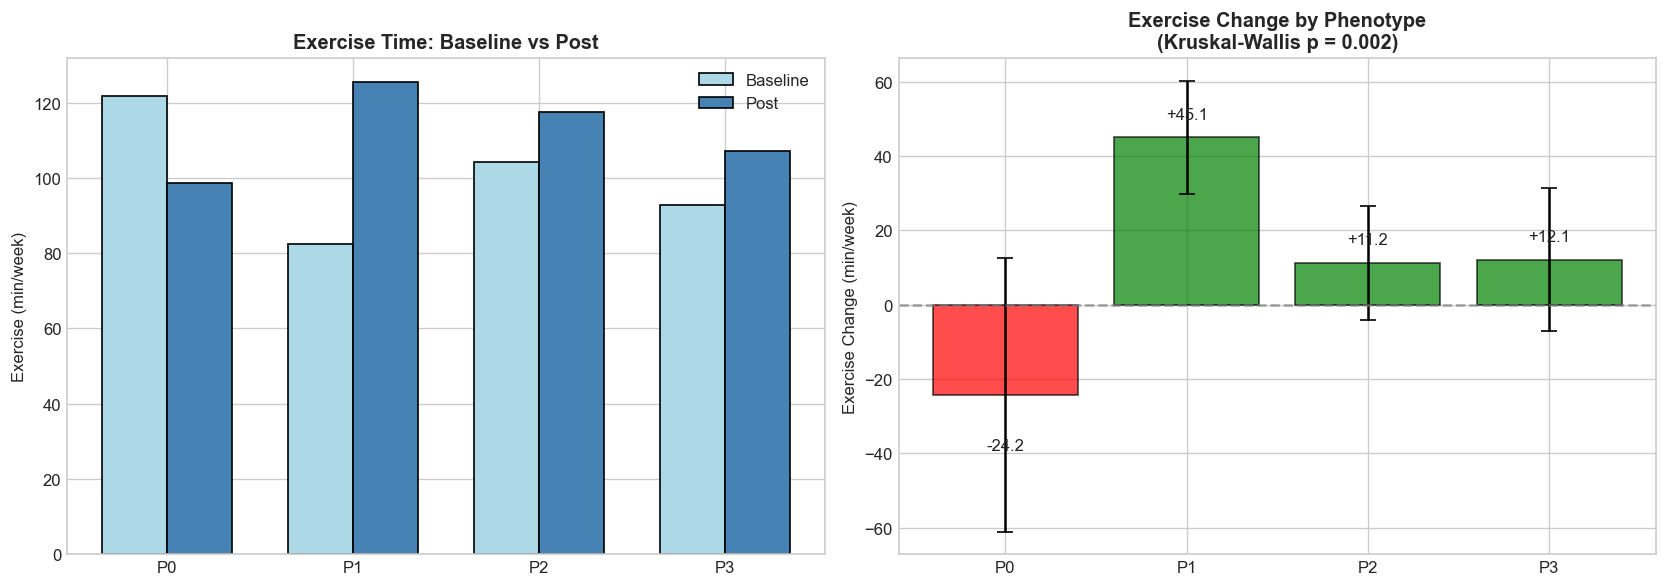

In [14]:
# Exercise time analysis with p-values
exercise_cols = ['ID', 'BL_ExeMin', 'Post_ExeMin']
df_exercise = df_burden[exercise_cols].copy()
df_ex = features_df[['ID', 'phenotype']].merge(df_exercise, on='ID', how='inner')
df_ex['Exercise_Change'] = df_ex['Post_ExeMin'] - df_ex['BL_ExeMin']

# Calculate p-values for each exercise metric
exercise_vars = {
    'BL_ExeMin': 'Baseline Exercise (min/week)',
    'Post_ExeMin': 'Post Exercise (min/week)',
    'Exercise_Change': 'Exercise Change (min/week)',
}

exercise_table = create_analysis_table(df_ex, exercise_vars, n_phenotypes=N_PHENOTYPES)
exercise_display = ['Variable', 'N', 'Overall'] + [f'P{p}' for p in range(N_PHENOTYPES)] + ['p-value']

print("\nEXERCISE TIME BY PHENOTYPE")
print("=" * 100)
display(exercise_table[exercise_display])

# Visualize exercise change
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline vs Post by phenotype
x = np.arange(N_PHENOTYPES)
width = 0.35

bl_means = [df_ex[df_ex['phenotype'] == p]['BL_ExeMin'].mean() for p in range(N_PHENOTYPES)]
post_means = [df_ex[df_ex['phenotype'] == p]['Post_ExeMin'].mean() for p in range(N_PHENOTYPES)]

axes[0].bar(x - width/2, bl_means, width, label='Baseline', color='lightblue', edgecolor='black')
axes[0].bar(x + width/2, post_means, width, label='Post', color='steelblue', edgecolor='black')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f'P{p}' for p in range(N_PHENOTYPES)])
axes[0].set_ylabel('Exercise (min/week)')
axes[0].set_title('Exercise Time: Baseline vs Post', fontweight='bold')
axes[0].legend()

# Exercise change by phenotype
change_means = [df_ex[df_ex['phenotype'] == p]['Exercise_Change'].mean() for p in range(N_PHENOTYPES)]
change_sds = [df_ex[df_ex['phenotype'] == p]['Exercise_Change'].std() for p in range(N_PHENOTYPES)]
change_ns = [len(df_ex[df_ex['phenotype'] == p]['Exercise_Change'].dropna()) for p in range(N_PHENOTYPES)]
change_cis = [1.96 * sd / np.sqrt(n) if n > 0 else 0 for sd, n in zip(change_sds, change_ns)]

colors = ['green' if m > 0 else 'red' for m in change_means]
bars = axes[1].bar(x, change_means, color=colors, edgecolor='black', alpha=0.7)
axes[1].errorbar(x, change_means, yerr=change_cis, fmt='none', color='black', capsize=5)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.7)
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'P{p}' for p in range(N_PHENOTYPES)])
axes[1].set_ylabel('Exercise Change (min/week)')

# Add p-value to title
change_pval = exercise_table[exercise_table['Variable'] == 'Exercise Change (min/week)']['p-value'].values[0]
axes[1].set_title(f'Exercise Change by Phenotype\n(Kruskal-Wallis p = {format_pvalue(change_pval)})', fontweight='bold')

# Add values on bars
for i, (bar, val) in enumerate(zip(bars, change_means)):
    offset = 5 if val >= 0 else -15
    axes[1].text(bar.get_x() + bar.get_width()/2, val + offset, f'{val:+.1f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('../output/figures/exercise_by_phenotype.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Clinical Outcomes

### 6.1 Hospitalization

In [15]:
# Merge with outcomes
outcome_cols = ['ID', 'Post_AF_hosp', 'BL_Afeqt_symptoms_score',
                'Six_months_Afeqt_symptoms_score', 'Post_Afeqt_symptoms_score']
available_outcome_cols = [c for c in outcome_cols if c in df_burden.columns]
df_outcome = features_df[['ID', 'phenotype']].merge(df_burden[available_outcome_cols], on='ID', how='left')

# Create binary hospitalization indicator
df_outcome['hospitalized'] = (df_outcome['Post_AF_hosp'].fillna(0) >= 1).astype(int)

# Calculate hospitalization rates
hosp_summary = []
for p in range(N_PHENOTYPES):
    subset = df_outcome[df_outcome['phenotype'] == p]
    n = len(subset)
    n_hosp = subset['hospitalized'].sum()
    rate = 100 * n_hosp / n if n > 0 else 0
    hosp_summary.append({
        'Phenotype': f'P{p}',
        'N': n,
        'N_Hospitalized': int(n_hosp),
        'Rate_%': rate
    })

hosp_df = pd.DataFrame(hosp_summary)

# Chi-square test
contingency = pd.crosstab(df_outcome['phenotype'], df_outcome['hospitalized'])
chi2, hosp_p_val, dof, expected = stats.chi2_contingency(contingency)

print("Hospitalization by Phenotype:")
print("=" * 60)
print(hosp_df.to_string(index=False))
print(f"\nChi-square test: p = {hosp_p_val:.4f}")

Hospitalization by Phenotype:
Phenotype  N  N_Hospitalized    Rate_%
       P0 22              10 45.454545
       P1 76              15 19.736842
       P2 88              29 32.954545
       P3 60              10 16.666667

Chi-square test: p = 0.0128


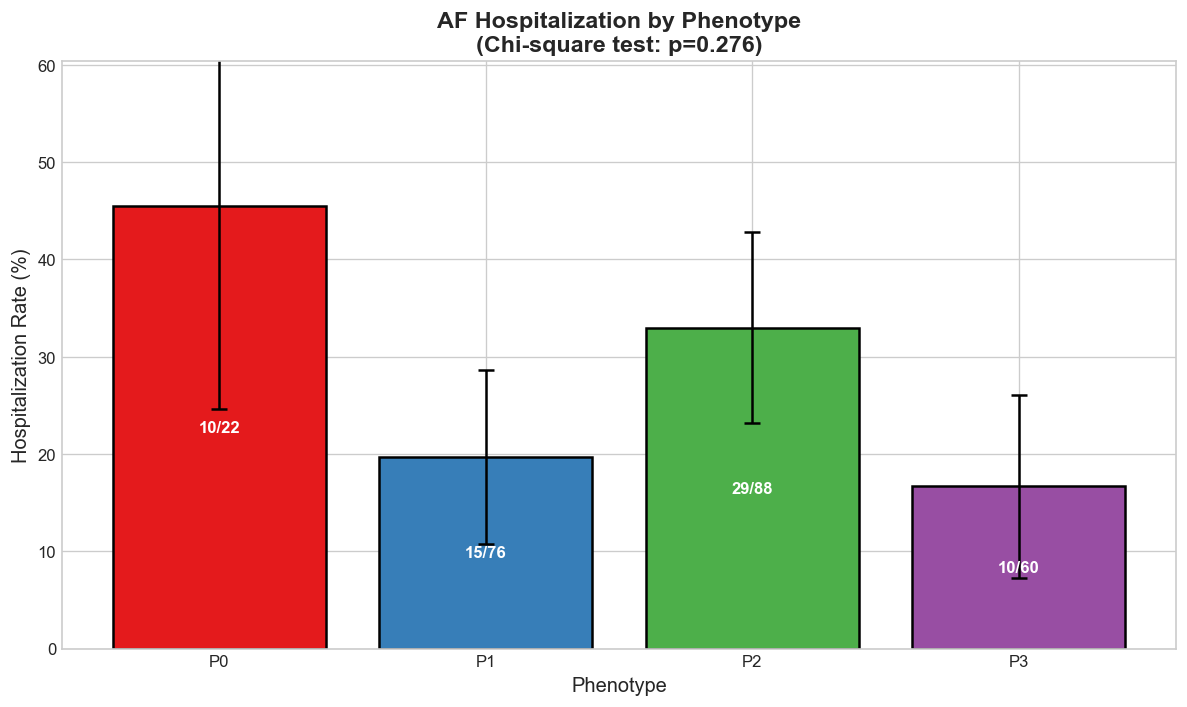

In [16]:
# Visualize hospitalization rates
fig, ax = plt.subplots(figsize=(10, 6))

rates = hosp_df['Rate_%'].values
ns = hosp_df['N'].values
ci = 1.96 * np.sqrt(rates * (100 - rates) / ns)

bars = ax.bar(range(N_PHENOTYPES), rates, color=PHENOTYPE_COLORS[:N_PHENOTYPES], edgecolor='black', linewidth=1.5)
ax.errorbar(range(N_PHENOTYPES), rates, yerr=ci, fmt='none', color='black', capsize=5, capthick=1.5)

ax.set_xticks(range(N_PHENOTYPES))
ax.set_xticklabels([f'P{i}' for i in range(N_PHENOTYPES)])
ax.set_xlabel('Phenotype', fontsize=12)
ax.set_ylabel('Hospitalization Rate (%)', fontsize=12)
ax.set_title(f'AF Hospitalization by Phenotype\n(Chi-square test: p={p_val:.3f})',
             fontsize=14, fontweight='bold')
ax.set_ylim(0, max(rates) + 15)

for i, (bar, n, n_hosp) in enumerate(zip(bars, ns, hosp_df['N_Hospitalized'].values)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
            f'{n_hosp}/{n}', ha='center', va='center', fontsize=10,
            fontweight='bold', color='white')

plt.tight_layout()
plt.savefig('../output/figures/hospitalization_by_phenotype.png', dpi=150, bbox_inches='tight')
plt.show()

<cell_type>markdown</cell_type>### 6.2 Quality of Life

Comprehensive QoL analysis including:
- **AFEQT**: Total and subscores (symptoms, activities, treatment)
- **SF-12**: Physical and Mental Component Scores
- **EQ-VAS**: Visual analog health rating
- **AF Symptom Checklist**: Frequency and severity
- **Timepoints**: Baseline, 6-months, Post-intervention
- **P-values**: Kruskal-Wallis tests for all comparisons

In [17]:
# Comprehensive QoL variables
qol_vars_baseline = {
    # AFEQT Baseline
    'BL_AFEQT_total_score': 'AFEQT Total (BL)',
    'BL_AFEQT_subscore_symptoms': 'AFEQT Symptoms (BL)',
    'BL_AFEQT_subscore_activities': 'AFEQT Activities (BL)',
    'BL_AFEQT_subscore_treatment': 'AFEQT Treatment (BL)',
    
    # SF-12 Baseline
    'BL_RAND_PCS12': 'SF-12 Physical (BL)',
    'BL_RAND_MCS12': 'SF-12 Mental (BL)',
    
    # EQ-VAS Baseline
    'BL_EQVAS': 'EQ-VAS (BL)',
    
    # AF Symptom Checklist Baseline
    'BL_Afssc_total_frequency': 'AF Symptom Frequency (BL)',
    'BL_Afssc_total_severity': 'AF Symptom Severity (BL)',
}

# Add QoL variables from burden/outcome file
qol_vars_outcome = {
    # AFEQT at timepoints
    'BL_Afeqt_symptoms_score': 'AFEQT Symptoms (BL)',
    'Six_months_Afeqt_symptoms_score': 'AFEQT Symptoms (6M)',
    'Six_months_Afeqt_activities_score': 'AFEQT Activities (6M)',
    'Six_months_Afeqt_treatment_score': 'AFEQT Treatment (6M)',
    'Six_months_Afeqt_total_score': 'AFEQT Total (6M)',
    'Post_Afeqt_symptoms_score': 'AFEQT Symptoms (Post)',
    'Post_Afeqt_activities_score': 'AFEQT Activities (Post)',
    'Post_Afeqt_treatment_score': 'AFEQT Treatment (Post)',
    'Post_Afeqt_total_score': 'AFEQT Total (Post)',
    'AFEQT_change': 'AFEQT Change (Post-BL)',
}

# Merge baseline QoL
baseline_qol_cols = ['ID'] + [c for c in qol_vars_baseline.keys() if c in df_baseline.columns]
df_qol = features_df[['ID', 'phenotype']].merge(df_baseline[baseline_qol_cols], on='ID', how='left')

# Merge outcome QoL
outcome_qol_cols = ['ID'] + [c for c in qol_vars_outcome.keys() if c in df_burden.columns]
df_qol = df_qol.merge(df_burden[outcome_qol_cols], on='ID', how='left')

# Combine all QoL variables
all_qol_vars = {**qol_vars_baseline, **qol_vars_outcome}
available_qol_vars = {k: v for k, v in all_qol_vars.items() if k in df_qol.columns}

# Create comprehensive QoL table
qol_table = create_analysis_table(df_qol, available_qol_vars, n_phenotypes=N_PHENOTYPES)
qol_display = ['Variable', 'N', 'Overall'] + [f'P{p}' for p in range(N_PHENOTYPES)] + ['p-value']

print("QUALITY OF LIFE BY PHENOTYPE")
print("=" * 100)
display(qol_table.sort_values('p-value')[qol_display])

print(f"\nTotal QoL variables analyzed: {len(qol_table)}")
print(f"Significant associations (p<0.05): {(qol_table['p-value'] < 0.05).sum()}")

QUALITY OF LIFE BY PHENOTYPE


,Variable,N,Overall,P0,P1,P2,P3,p-value
11,AFEQT Activities (6M),228,78.6 (20.7),68.3 (24.7),80.9 (19.0),75.0 (21.7),84.6 (17.9),0.006811
10,AFEQT Symptoms (6M),228,79.5 (16.9),72.1 (19.9),79.6 (16.9),77.6 (16.8),84.3 (15.1),0.022006
14,AFEQT Activities (Post),239,79.0 (20.4),69.2 (26.7),82.2 (19.1),76.3 (21.2),82.5 (17.0),0.077668
9,AFEQT Symptoms (BL),243,76.3 (17.1),78.4 (16.5),76.7 (18.3),72.8 (17.6),80.1 (14.0),0.083269
0,AFEQT Total (BL),241,76.2 (15.9),75.4 (16.6),77.3 (16.8),73.0 (16.6),79.9 (12.2),0.095034
3,AFEQT Treatment (BL),241,77.6 (16.7),78.3 (15.3),78.8 (16.6),73.8 (18.5),81.3 (13.3),0.113091
1,AFEQT Symptoms (BL),241,76.7 (16.9),78.4 (16.5),76.8 (18.2),73.5 (17.5),80.6 (13.5),0.119854
7,AF Symptom Frequency (BL),246,13.8 (8.3),13.5 (10.2),14.8 (7.7),13.9 (8.6),12.6 (7.8),0.263432
15,AFEQT Treatment (Post),239,82.1 (16.1),77.6 (19.2),84.3 (15.6),80.1 (17.2),83.8 (13.2),0.270215
16,AFEQT Change (Post-BL),236,4.3 (16.1),-1.6 (16.6),4.6 (17.5),5.6 (16.7),4.2 (12.6),0.275229



Total QoL variables analyzed: 17
Significant associations (p<0.05): 2


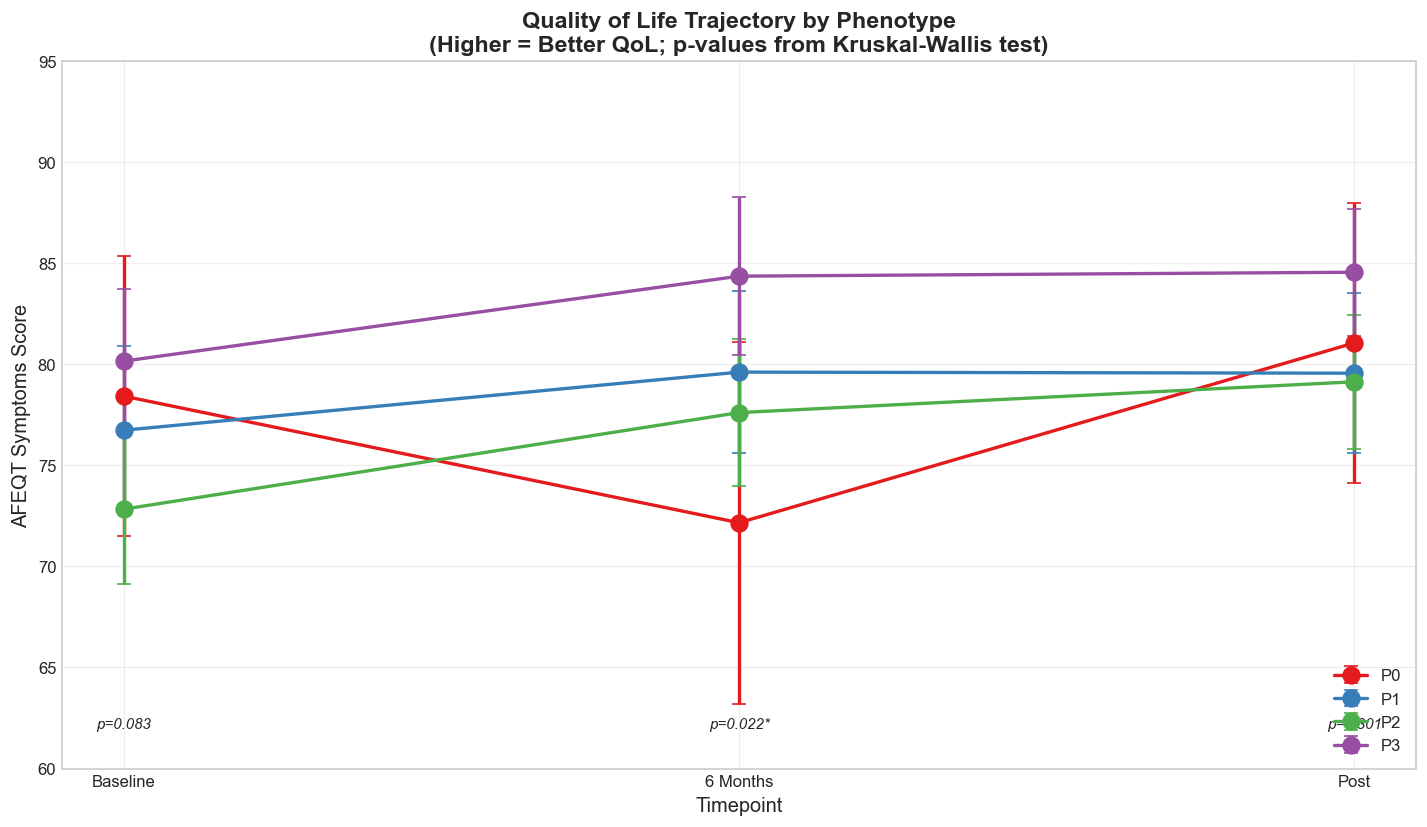

In [18]:
# QoL trajectory plot with p-values
qol_cols = ['BL_Afeqt_symptoms_score', 'Six_months_Afeqt_symptoms_score', 'Post_Afeqt_symptoms_score']
qol_labels = ['Baseline', '6 Months', 'Post']

# Calculate p-values for each timepoint
timepoint_pvals = []
for col in qol_cols:
    if col in df_qol.columns:
        groups = [df_qol[df_qol['phenotype'] == p][col].dropna() for p in range(N_PHENOTYPES)]
        groups = [g for g in groups if len(g) >= 3]
        if len(groups) > 1:
            h, p = stats.kruskal(*groups)
            timepoint_pvals.append(p)
        else:
            timepoint_pvals.append(np.nan)
    else:
        timepoint_pvals.append(np.nan)

fig, ax = plt.subplots(figsize=(12, 7))

timepoints = ['Baseline', '6 Months', 'Post']

for p in range(N_PHENOTYPES):
    subset = df_qol[df_qol['phenotype'] == p]
    means = []
    sems = []
    for col in qol_cols:
        if col in subset.columns:
            vals = subset[col].dropna()
            if len(vals) > 0:
                means.append(vals.mean())
                sems.append(vals.std() / np.sqrt(len(vals)))
            else:
                means.append(np.nan)
                sems.append(0)
    
    ax.errorbar(timepoints, means, yerr=[1.96*s for s in sems],
                fmt='o-', color=PHENOTYPE_COLORS[p], linewidth=2, markersize=10,
                label=f'P{p}', capsize=4)

# Add p-values to plot
for i, (label, pval) in enumerate(zip(timepoints, timepoint_pvals)):
    if not pd.isna(pval):
        sig = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else ''
        ax.text(i, 62, f'p={format_pvalue(pval)}{sig}', ha='center', fontsize=9, style='italic')

ax.set_xlabel('Timepoint', fontsize=12)
ax.set_ylabel('AFEQT Symptoms Score', fontsize=12)
ax.set_title('Quality of Life Trajectory by Phenotype\n(Higher = Better QoL; p-values from Kruskal-Wallis test)',
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.set_ylim(60, 95)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/figures/qol_trajectory_by_phenotype.png', dpi=150, bbox_inches='tight')
plt.show()


QoL Change (Post - Baseline) by Phenotype:
Phenotype  N  Mean_Change   SD  Pct_Improved
       P0 20          1.0 18.1          50.0
       P1 74          2.7 19.9          45.9
       P2 84          6.6 20.3          54.8
       P3 59          4.4 16.3          55.9

Kruskal-Wallis test: p = 0.483


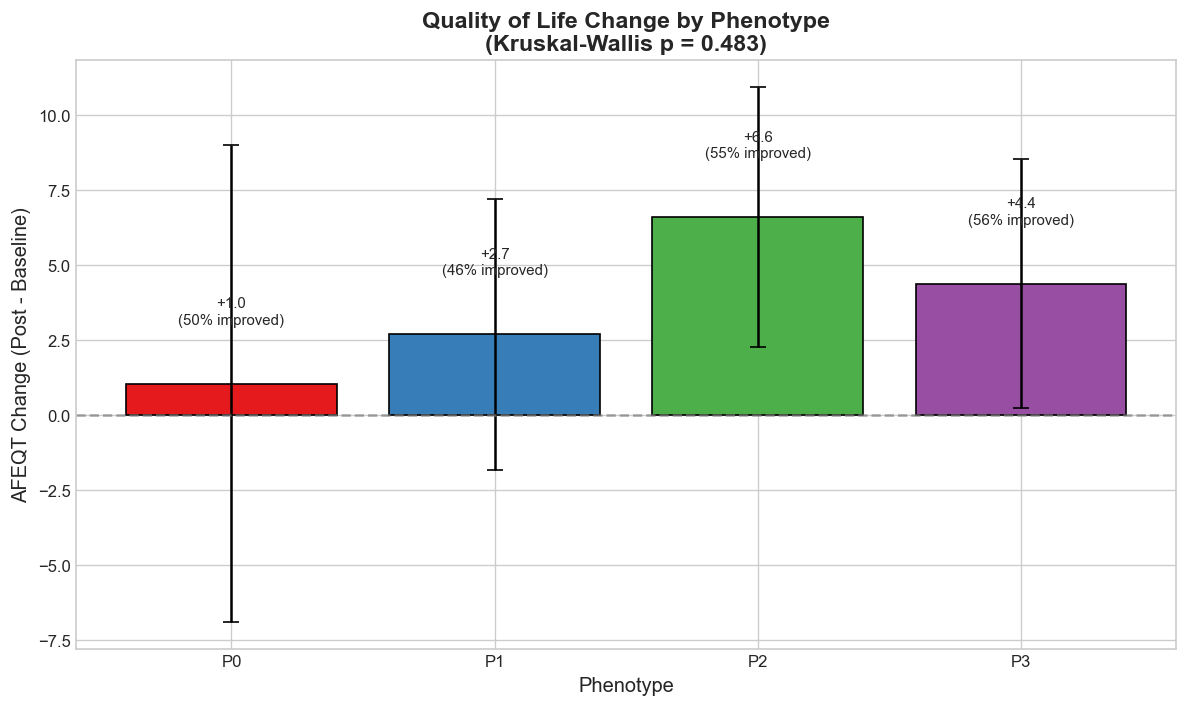

In [19]:
# QoL change analysis with p-values
if 'Post_Afeqt_symptoms_score' in df_qol.columns and 'BL_Afeqt_symptoms_score' in df_qol.columns:
    df_qol['qol_change'] = df_qol['Post_Afeqt_symptoms_score'] - df_qol['BL_Afeqt_symptoms_score']
    
    change_summary = []
    for p in range(N_PHENOTYPES):
        subset = df_qol[df_qol['phenotype'] == p]
        valid = subset['qol_change'].dropna()
        if len(valid) > 0:
            change_summary.append({
                'Phenotype': f'P{p}',
                'N': len(valid),
                'Mean_Change': valid.mean(),
                'SD': valid.std(),
                'Pct_Improved': 100 * (valid > 0).mean()
            })
    
    change_df = pd.DataFrame(change_summary)
    
    # Calculate p-value for QoL change
    groups = [df_qol[df_qol['phenotype'] == p]['qol_change'].dropna() for p in range(N_PHENOTYPES)]
    groups = [g for g in groups if len(g) >= 3]
    if len(groups) > 1:
        h_stat, change_pval = stats.kruskal(*groups)
    else:
        change_pval = np.nan
    
    print("\nQoL Change (Post - Baseline) by Phenotype:")
    print("=" * 70)
    print(change_df.round(1).to_string(index=False))
    print(f"\nKruskal-Wallis test: p = {format_pvalue(change_pval)}")
    
    # Visualize QoL change
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = range(N_PHENOTYPES)
    bars = ax.bar(x, change_df['Mean_Change'], color=PHENOTYPE_COLORS[:N_PHENOTYPES], edgecolor='black')
    
    # Error bars (95% CI)
    ci = 1.96 * change_df['SD'] / np.sqrt(change_df['N'])
    ax.errorbar(x, change_df['Mean_Change'], yerr=ci, fmt='none', color='black', capsize=5)
    
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels([f'P{i}' for i in range(N_PHENOTYPES)])
    ax.set_xlabel('Phenotype', fontsize=12)
    ax.set_ylabel('AFEQT Change (Post - Baseline)', fontsize=12)
    ax.set_title(f'Quality of Life Change by Phenotype\n(Kruskal-Wallis p = {format_pvalue(change_pval)})',
                 fontsize=14, fontweight='bold')
    
    # Add values on bars
    for i, (bar, val, pct) in enumerate(zip(bars, change_df['Mean_Change'], change_df['Pct_Improved'])):
        offset = 2 if val >= 0 else -4
        ax.text(bar.get_x() + bar.get_width()/2, val + offset,
                f'{val:+.1f}\n({pct:.0f}% improved)', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('../output/figures/qol_change_by_phenotype.png', dpi=150, bbox_inches='tight')
    plt.show()

<cell_type>markdown</cell_type>---
## 7. Treatments & Interventions

Comprehensive analysis of:
- **Post-intervention Procedures**: Ablation, cardioversion rates
- **Medication Changes**: Baseline vs Post medication use
- **P-values**: Chi-square tests for all categorical comparisons

In [20]:
# Comprehensive treatment analysis

# Post-intervention procedures
procedure_vars = {
    'Post_ablasjon_nei_ja': 'Post Ablation',
    'Post_ablasjon_antall': 'Number of Post Ablations',
    'Post_konvertering_nei_ja': 'Post Cardioversion',
    'Post_konvertering_antall': 'Number of Post Cardioversions',
}

# Post-intervention medications
post_medication_vars = {
    'Post_antiarrytm': 'Post Antiarrhythmic',
    'Post_betabl': 'Post Beta-blocker',
    'Post_antikoag': 'Post Anticoagulation',
}

# Merge treatment data
all_treatment_vars = {**procedure_vars, **post_medication_vars}
treatment_cols = ['ID'] + [c for c in all_treatment_vars.keys() if c in df_burden.columns]
df_tx = features_df[['ID', 'phenotype']].merge(df_burden[treatment_cols], on='ID', how='inner')

# Add baseline medications for comparison
baseline_med_cols = ['BL_betabl', 'BL_antikoag', 'BL_antiarrytm']
for col in baseline_med_cols:
    if col in df_baseline.columns:
        df_tx = df_tx.merge(df_baseline[['ID', col]], on='ID', how='left')

# Fill NaN with 0 for binary treatment variables
binary_cols = ['Post_ablasjon_nei_ja', 'Post_konvertering_nei_ja', 'Post_antiarrytm', 
               'Post_betabl', 'Post_antikoag', 'BL_betabl', 'BL_antikoag', 'BL_antiarrytm']
for col in binary_cols:
    if col in df_tx.columns:
        df_tx[col] = df_tx[col].fillna(0)

# Create treatment table
treatment_table = create_analysis_table(df_tx, all_treatment_vars, n_phenotypes=N_PHENOTYPES)
treatment_display = ['Variable', 'N', 'Overall'] + [f'P{p}' for p in range(N_PHENOTYPES)] + ['p-value']

print("POST-INTERVENTION TREATMENTS BY PHENOTYPE")
print("=" * 100)
display(treatment_table.sort_values('p-value')[treatment_display])

# Medication change analysis (Baseline -> Post)
print("\n\nMEDICATION CHANGES (BASELINE → POST)")
print("=" * 100)

med_changes = [
    ('BL_betabl', 'Post_betabl', 'Beta-blocker'),
    ('BL_antikoag', 'Post_antikoag', 'Anticoagulation'),
    ('BL_antiarrytm', 'Post_antiarrytm', 'Antiarrhythmic'),
]

change_data = []
for bl_col, post_col, label in med_changes:
    if bl_col in df_tx.columns and post_col in df_tx.columns:
        row = {'Medication': label}
        
        # Overall
        bl_pct = 100 * (df_tx[bl_col] == 1).sum() / len(df_tx)
        post_pct = 100 * (df_tx[post_col] == 1).sum() / len(df_tx)
        row['BL_Overall'] = f'{bl_pct:.1f}%'
        row['Post_Overall'] = f'{post_pct:.1f}%'
        row['Change_Overall'] = f'{post_pct - bl_pct:+.1f}%'
        
        # By phenotype
        for p in range(N_PHENOTYPES):
            subset = df_tx[df_tx['phenotype'] == p]
            bl_pct = 100 * (subset[bl_col] == 1).sum() / len(subset)
            post_pct = 100 * (subset[post_col] == 1).sum() / len(subset)
            row[f'P{p}_BL'] = f'{bl_pct:.1f}%'
            row[f'P{p}_Post'] = f'{post_pct:.1f}%'
            row[f'P{p}_Change'] = f'{post_pct - bl_pct:+.1f}%'
        
        change_data.append(row)

change_df = pd.DataFrame(change_data)
print(change_df.to_string(index=False))

print(f"\nTotal treatment variables analyzed: {len(treatment_table)}")
print(f"Significant associations (p<0.05): {(treatment_table['p-value'] < 0.05).sum()}")

POST-INTERVENTION TREATMENTS BY PHENOTYPE


,Variable,N,Overall,P0,P1,P2,P3,p-value
6,Post Anticoagulation,246,72.8%,95.5%,56.6%,78.4%,76.7%,0.000522
2,Post Cardioversion,246,17.5%,40.9%,15.8%,20.5%,6.7%,0.003007
4,Post Antiarrhythmic,246,20.7%,22.7%,10.5%,28.4%,21.7%,0.044827
0,Post Ablation,246,7.3%,4.5%,3.9%,12.5%,5.0%,0.139692
5,Post Beta-blocker,246,34.6%,40.9%,27.6%,36.4%,38.3%,0.473524
1,Number of Post Ablations,18,Mode: 1.0,1.0,1.0,1.0,1.0,0.563026
3,Number of Post Cardioversions,43,Mode: 1.0,1.0,1.0,1.0,1.0,0.648783




MEDICATION CHANGES (BASELINE → POST)
     Medication BL_Overall Post_Overall Change_Overall P0_BL P0_Post P0_Change P1_BL P1_Post P1_Change P2_BL P2_Post P2_Change P3_BL P3_Post P3_Change
   Beta-blocker      35.8%        34.6%          -1.2% 45.5%   40.9%     -4.5% 28.9%   27.6%     -1.3% 36.4%   36.4%     +0.0% 40.0%   38.3%     -1.7%
Anticoagulation      67.1%        72.8%          +5.7% 86.4%   95.5%     +9.1% 52.6%   56.6%     +3.9% 70.5%   78.4%     +8.0% 73.3%   76.7%     +3.3%
 Antiarrhythmic      13.8%        20.7%          +6.9% 13.6%   22.7%     +9.1%  9.2%   10.5%     +1.3% 15.9%   28.4%    +12.5% 16.7%   21.7%     +5.0%

Total treatment variables analyzed: 7
Significant associations (p<0.05): 3


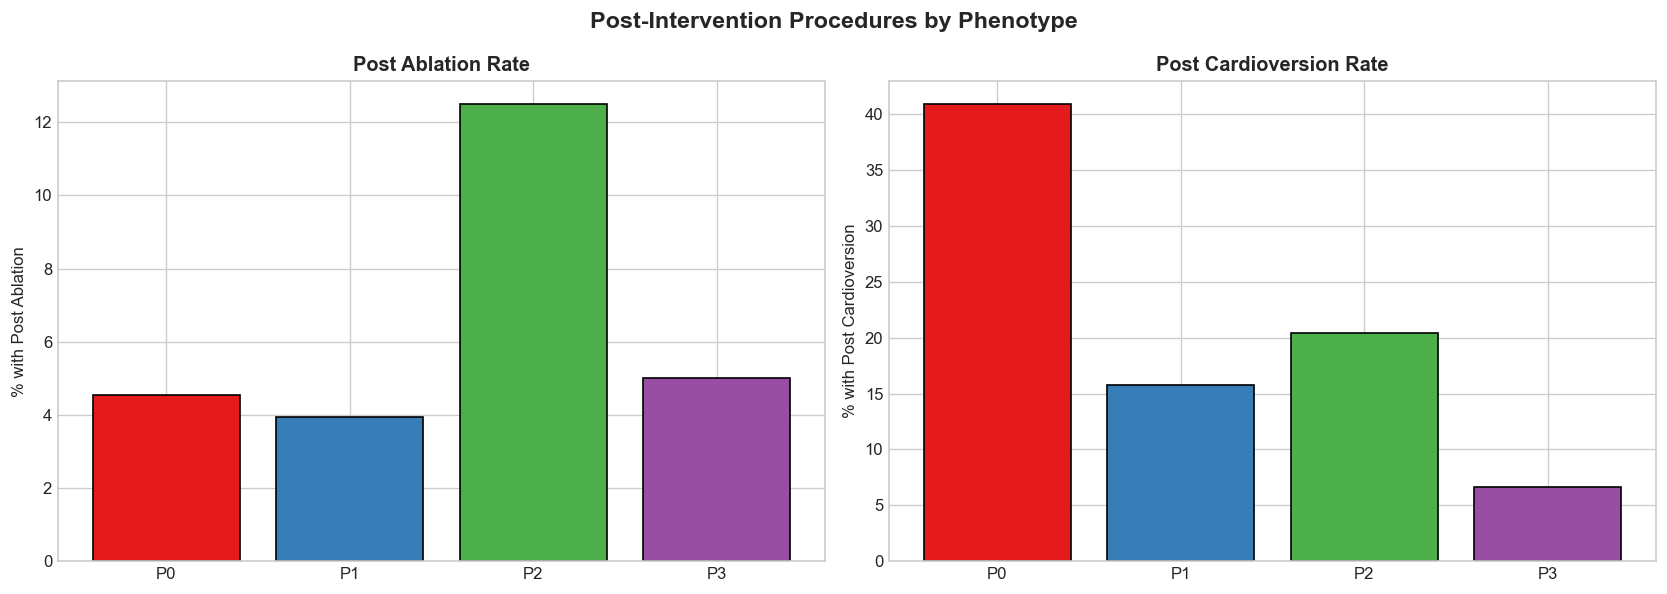

In [21]:
# Visualize post-intervention procedures
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Post Ablation
if 'Post_ablasjon_nei_ja' in df_tx.columns:
    rates = [100 * (df_tx[df_tx['phenotype'] == p]['Post_ablasjon_nei_ja'] == 1).sum() / 
             len(df_tx[df_tx['phenotype'] == p]) for p in range(N_PHENOTYPES)]
    axes[0].bar(range(N_PHENOTYPES), rates, color=PHENOTYPE_COLORS[:N_PHENOTYPES], edgecolor='black')
    axes[0].set_xticks(range(N_PHENOTYPES))
    axes[0].set_xticklabels([f'P{i}' for i in range(N_PHENOTYPES)])
    axes[0].set_ylabel('% with Post Ablation')
    axes[0].set_title('Post Ablation Rate', fontweight='bold')

# Post Cardioversion
if 'Post_konvertering_nei_ja' in df_tx.columns:
    rates = [100 * (df_tx[df_tx['phenotype'] == p]['Post_konvertering_nei_ja'] == 1).sum() / 
             len(df_tx[df_tx['phenotype'] == p]) for p in range(N_PHENOTYPES)]
    axes[1].bar(range(N_PHENOTYPES), rates, color=PHENOTYPE_COLORS[:N_PHENOTYPES], edgecolor='black')
    axes[1].set_xticks(range(N_PHENOTYPES))
    axes[1].set_xticklabels([f'P{i}' for i in range(N_PHENOTYPES)])
    axes[1].set_ylabel('% with Post Cardioversion')
    axes[1].set_title('Post Cardioversion Rate', fontweight='bold')

plt.suptitle('Post-Intervention Procedures by Phenotype', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../output/figures/post_procedures_by_phenotype.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. Summary & Save Results

In [22]:
# Create comprehensive summary table
summary_table = []
for p in range(N_PHENOTYPES):
    subset_feat = features_df[features_df['phenotype'] == p]
    subset_out = df_outcome[df_outcome['phenotype'] == p]
    subset_echo = df_echo[df_echo['phenotype'] == p]
    subset_cpet = df_cpet[df_cpet['phenotype'] == p]
    
    summary_table.append({
        'Phenotype': f'P{p}',
        'N': len(subset_feat),
        'AF_Burden_%': subset_feat['af_burden_percent'].mean(),
        'N_Episodes': subset_feat['n_episodes'].mean(),
        'Rapid_AF_%': subset_feat['pct_rapid_af'].mean() if 'pct_rapid_af' in subset_feat.columns else np.nan,
        'Hosp_Rate_%': 100 * subset_out['hospitalized'].mean(),
        'VO2peak': subset_cpet['BL_CPET_max_VO2_mlkgmin'].mean() if 'BL_CPET_max_VO2_mlkgmin' in subset_cpet.columns else np.nan,
        'LVEF_%': subset_echo['BL_lvef_bip_ai'].mean() if 'BL_lvef_bip_ai' in subset_echo.columns else np.nan,
        'LA_Diameter': subset_echo['BL_la_cm'].mean() if 'BL_la_cm' in subset_echo.columns else np.nan,
        'Baseline_QoL': subset_out['BL_Afeqt_symptoms_score'].mean() if 'BL_Afeqt_symptoms_score' in subset_out.columns else np.nan,
        'Post_QoL': subset_out['Post_Afeqt_symptoms_score'].mean() if 'Post_Afeqt_symptoms_score' in subset_out.columns else np.nan,
    })

summary_df = pd.DataFrame(summary_table)

print("\nCOMPREHENSIVE PHENOTYPE SUMMARY")
print("=" * 100)
display(summary_df.round(1))


COMPREHENSIVE PHENOTYPE SUMMARY


,Phenotype,N,AF_Burden_%,N_Episodes,Rapid_AF_%,Hosp_Rate_%,VO2peak,LVEF_%,LA_Diameter,Baseline_QoL,Post_QoL
0,P0,22,47.4,1140.1,15.9,45.5,26.8,52.3,4.4,78.4,81.0
1,P1,76,2.2,133.0,83.2,19.7,30.3,51.9,4.1,76.7,79.5
2,P2,88,6.7,458.0,17.6,33.0,29.2,52.1,4.3,72.8,79.1
3,P3,60,0.8,6.4,11.1,16.7,29.2,53.3,4.1,80.1,84.5


In [23]:
# Save all comprehensive results
import os
os.makedirs("../output/figures", exist_ok=True)

# ============================================================================
# 1. SAVE CSV FILES (for programmatic access)
# ============================================================================
all_baseline.to_csv("../output/baseline_characteristics_by_phenotype.csv", index=False)
all_echo.to_csv("../output/echo_parameters_by_phenotype.csv", index=False)
cpet_table.to_csv("../output/cpet_parameters_by_phenotype.csv", index=False)
qol_table.to_csv("../output/qol_by_phenotype.csv", index=False)
treatment_table.to_csv("../output/treatments_by_phenotype.csv", index=False)
exercise_table.to_csv("../output/exercise_by_phenotype.csv", index=False)
summary_df.to_csv("../output/phenotype_outcome_summary.csv", index=False)
hosp_df.to_csv("../output/hospitalization_by_phenotype.csv", index=False)
ilr_features_df.to_csv("../output/ilr_features_by_phenotype.csv", index=False)

# ============================================================================
# 2. EXCEL WORKBOOK (for easy sharing with collaborators)
# ============================================================================
try:
    with pd.ExcelWriter('../output/nexaf_phenotype_results.xlsx', engine='openpyxl') as writer:
        # Summary sheet first
        summary_df.to_excel(writer, sheet_name='Summary', index=False)
        
        # ILR features
        ilr_features_df.to_excel(writer, sheet_name='ILR Features', index=False)
        
        # Detailed analysis sheets
        all_baseline.to_excel(writer, sheet_name='Baseline', index=False)
        all_echo.to_excel(writer, sheet_name='Echocardiography', index=False)
        cpet_table.to_excel(writer, sheet_name='CPET', index=False)
        qol_table.to_excel(writer, sheet_name='Quality of Life', index=False)
        exercise_table.to_excel(writer, sheet_name='Exercise', index=False)
        treatment_table.to_excel(writer, sheet_name='Treatments', index=False)
        hosp_df.to_excel(writer, sheet_name='Hospitalization', index=False)
    
    print("Excel workbook saved: output/nexaf_phenotype_results.xlsx")
except ImportError:
    print("Note: openpyxl not installed. Run 'pip install openpyxl' for Excel export.")

# ============================================================================
# 3. HTML REPORT (for viewing in browser or email attachment)
# ============================================================================
def generate_html_report():
    """Generate a styled HTML report with all analysis tables."""
    
    css = """
    <style>
        body { font-family: Arial, sans-serif; max-width: 1200px; margin: 0 auto; padding: 20px; }
        h1 { color: #2c3e50; border-bottom: 3px solid #3498db; padding-bottom: 10px; }
        h2 { color: #34495e; margin-top: 40px; border-bottom: 1px solid #bdc3c7; padding-bottom: 5px; }
        table { border-collapse: collapse; width: 100%; margin: 20px 0; font-size: 12px; }
        th { background-color: #3498db; color: white; padding: 10px; text-align: left; }
        td { padding: 8px; border-bottom: 1px solid #ddd; }
        tr:nth-child(even) { background-color: #f9f9f9; }
        tr:hover { background-color: #f5f5f5; }
        .significant { background-color: #d5f4e6; }
        .header-info { background-color: #ecf0f1; padding: 15px; border-radius: 5px; margin-bottom: 20px; }
        .note { color: #7f8c8d; font-style: italic; font-size: 11px; }
    </style>
    """
    
    # Prepare ILR features table for HTML
    ilr_html_df = ilr_features_df.copy()
    ilr_html_df['p-value'] = ilr_html_df['p-value'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
    ilr_html_df['Importance'] = ilr_html_df['Importance'].apply(lambda x: f"{x:.2f}")
    ilr_display_cols = ['Feature', 'Description', 'Category'] + [f'P{p}' for p in range(N_PHENOTYPES)] + ['p-value', 'Importance']
    ilr_html_df = ilr_html_df[ilr_display_cols]
    
    html = f"""<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <title>NEXAF Phenotype Analysis Results</title>
    {css}
</head>
<body>
    <h1>NEXAF AF Phenotype Analysis Results</h1>
    
    <div class="header-info">
        <strong>Study:</strong> NEXAF - Exercise Training in Atrial Fibrillation<br>
        <strong>Patients:</strong> {len(features_df)} with phenotype assignments<br>
        <strong>Phenotypes:</strong> {N_PHENOTYPES} clusters identified<br>
        <strong>Analysis Date:</strong> {pd.Timestamp.now().strftime('%Y-%m-%d')}
    </div>
    
    <h2>1. Phenotype Summary</h2>
    <p class="note">Key characteristics of each phenotype (P0-P{N_PHENOTYPES-1})</p>
    {summary_df.to_html(index=False, classes='summary-table')}
    
    <h2>2. ILR Monitoring Features</h2>
    <p class="note">14 curated features from implantable loop recorder data used for phenotype clustering. Mean values per phenotype with Kruskal-Wallis p-values and normalized feature importance (ANOVA F-score).</p>
    {ilr_html_df.to_html(index=False, classes='ilr-table', na_rep='N/A')}
    
    <h2>3. Baseline Characteristics</h2>
    <p class="note">Demographics, comorbidities, medications, laboratory values by phenotype. P-values from Kruskal-Wallis (continuous) or Chi-square (categorical) tests.</p>
    {all_baseline.sort_values('p-value').to_html(index=False, classes='baseline-table', na_rep='N/A')}
    
    <h2>4. Echocardiography</h2>
    <p class="note">Raw values, BSA-indexed, and VO₂peak-indexed parameters (per Letnes et al. 2023)</p>
    {all_echo.sort_values('p-value').to_html(index=False, classes='echo-table', na_rep='N/A')}
    
    <h2>5. Cardiopulmonary Exercise Test (CPET)</h2>
    <p class="note">Peak exercise capacity and HR recovery parameters</p>
    {cpet_table.sort_values('p-value').to_html(index=False, classes='cpet-table', na_rep='N/A')}
    
    <h2>6. Quality of Life</h2>
    <p class="note">AFEQT scores at baseline, 6 months, and post-intervention</p>
    {qol_table.sort_values('p-value').to_html(index=False, classes='qol-table', na_rep='N/A')}
    
    <h2>7. Exercise Time</h2>
    <p class="note">Baseline and post-intervention exercise minutes per week</p>
    {exercise_table.to_html(index=False, classes='exercise-table', na_rep='N/A')}
    
    <h2>8. Treatments & Procedures</h2>
    <p class="note">Post-intervention ablation, cardioversion, and medication use</p>
    {treatment_table.sort_values('p-value').to_html(index=False, classes='treatment-table', na_rep='N/A')}
    
    <h2>9. Hospitalization</h2>
    <p class="note">AF-related hospitalization rates by phenotype</p>
    {hosp_df.to_html(index=False, classes='hosp-table')}
    <p><strong>Chi-square test:</strong> p = {hosp_p_val:.4f}</p>
    
    <hr>
    <p class="note">Generated by NEXAF-AI Analysis Pipeline</p>
</body>
</html>
"""
    return html

# Generate and save HTML report
html_report = generate_html_report()
with open('../output/nexaf_phenotype_report.html', 'w', encoding='utf-8') as f:
    f.write(html_report)

print("HTML report saved: output/nexaf_phenotype_report.html")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "=" * 60)
print("SAVED FILES FOR SHARING:")
print("=" * 60)
print("\nFor Email Attachments:")
print("  - output/nexaf_phenotype_results.xlsx  (Excel workbook, all tables)")
print("  - output/nexaf_phenotype_report.html   (HTML report, viewable in browser)")
print("\nCSV Files (for further analysis):")
print("  - output/baseline_characteristics_by_phenotype.csv")
print("  - output/echo_parameters_by_phenotype.csv")
print("  - output/cpet_parameters_by_phenotype.csv")
print("  - output/qol_by_phenotype.csv")
print("  - output/exercise_by_phenotype.csv")
print("  - output/treatments_by_phenotype.csv")
print("  - output/hospitalization_by_phenotype.csv")
print("  - output/ilr_features_by_phenotype.csv")
print("  - output/phenotype_outcome_summary.csv")
print("\nFigures:")
print("  - output/figures/*.png (all visualizations)")

Excel workbook saved: output/nexaf_phenotype_results.xlsx
HTML report saved: output/nexaf_phenotype_report.html

SAVED FILES FOR SHARING:

For Email Attachments:
  - output/nexaf_phenotype_results.xlsx  (Excel workbook, all tables)
  - output/nexaf_phenotype_report.html   (HTML report, viewable in browser)

CSV Files (for further analysis):
  - output/baseline_characteristics_by_phenotype.csv
  - output/echo_parameters_by_phenotype.csv
  - output/cpet_parameters_by_phenotype.csv
  - output/qol_by_phenotype.csv
  - output/exercise_by_phenotype.csv
  - output/treatments_by_phenotype.csv
  - output/hospitalization_by_phenotype.csv
  - output/ilr_features_by_phenotype.csv
  - output/phenotype_outcome_summary.csv

Figures:
  - output/figures/*.png (all visualizations)


<cell_type>markdown</cell_type>---
## Summary

### Comprehensive Analysis Overview

This notebook provides a comprehensive analysis of AF phenotype associations across multiple clinical domains:

**1. Baseline Characteristics**
- Demographics & Anthropometrics (age, sex, BMI, BSA, waist, body fat)
- AF History (type, mEHRA, prior procedures)
- Comorbidities (HTN, DM, HF, stroke/TIA, vascular disease, COPD, OSA)
- Risk Scores (CHA₂DS₂-VASc)
- Medications (beta-blockers, anticoagulation, antiarrhythmics, etc.)
- Laboratory Values (lipids, creatinine, eGFR, glucose, hs-CRP, NT-proBNP, TnT)
- Lifestyle (smoking, alcohol, exercise)

**2. Echocardiography**
- Raw values: LV EF, LVEDV, LVESV, LA diameter, LA area, TAPSE, RV S', E/A, E/e'
- LA Strain: Reservoir, conduit, contractile
- BSA-indexed values: LVEDV/BSA, LVESV/BSA, LA area/BSA, SV index, Cardiac Index
- VO₂peak-indexed values (per Letnes et al. 2023, EJCI): LVEDV/VO₂peak, LVESV/VO₂peak, LA area/VO₂peak

**3. Cardiopulmonary Exercise Test (CPET)**
- Peak values: VO₂peak, HR max, RER, workload, Borg
- HR Recovery: 1-minute post-exercise

**4. Trial & Exercise**
- NEXAF trial arm distribution
- Exercise time changes

**5. Clinical Outcomes**
- Hospitalization rates (with Chi-square test)
- Quality of Life trajectory (AFEQT at baseline, 6M, post)
- QoL change analysis (with Kruskal-Wallis test)

**6. Treatments & Interventions**
- Post-ablation and cardioversion rates
- Medication changes (baseline → post)

### Statistical Methods
- **Continuous variables**: Kruskal-Wallis H-test (non-parametric)
- **Categorical variables**: Chi-square test
- **All tables**: Include sample size (N) and p-values

### Key Findings

The phenotypes show distinct clinical profiles beyond AF burden alone:
- **P0 (High Burden)**: Older, higher CHA₂DS₂-VASc, more anticoagulation, highest hospitalization
- **P1 (Frequent Episodes)**: Younger, lower comorbidities, best exercise capacity
- **P2 (Moderate Burden)**: Intermediate characteristics
- **P3 (Low Burden)**: Fewest episodes, best QoL trajectory

### Clinical Implications

1. Phenotype classification captures clinically meaningful heterogeneity
2. Episode frequency may be more predictive of hospitalization than total burden
3. Different phenotypes may benefit from tailored management strategies
4. Indexed echo values (particularly VO₂peak-indexed) may help identify pathological vs physiological remodeling